# CRUST1 Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the CRUST1 Moho inversion for South America from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. This is a semi-synthetic model, where true Moho topography data from CRUST1 is used to forward model the observed gravity. This synthetic gravity data is then used to invert for Moho topography. We start by following their approach, but using Invert4Geom. We follow this by using our own approach of incorporating a starting model and adhering to points of known Moho elevation.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import pickle

import numpy as np
import pandas as pd
import pooch
import pyproj
import verde as vd
import xarray as xr
from polartoolkit import fetch, maps
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



# Get datasets

Here we use `Pooch` to download the CRUST1 global Moho topography dataset, and the locations of seismic measurements of Moho depth for South America. We perform some preprocessing on these datasets, subsetting them to match the geographic extent used in the paper. We convert the data to projected coordinates, instead of the geographic coordinates used in the paper.

In [2]:
url = "https://igppweb.ucsd.edu/~gabi/crust1/depthtomoho.xyz.zip"
known_hash = "36089a537ed45795557999003d0eada9935f1cc589a6ddb486a7eac716dc7ff2"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
    processor=pooch.Unzip(),
)[0]

df = pd.read_csv(path, header=None, sep=r"\s+", names=["lon", "lat", "upward"])

# turn elevation to meters
df["upward"] = df.upward * 1000

# turn into grid
true_moho = df.set_index(["lat", "lon"]).to_xarray().rio.write_crs("EPSG:4326").upward

# subset to south america with buffer
region_ll = (-92, -28, -62, 22)
true_moho = true_moho.sel(
    lon=slice(region_ll[0], region_ll[1]),
    lat=slice(region_ll[2], region_ll[3]),
).drop_vars("spatial_ref")

shape = (80, 60)  # n, e

# We're choosing the latitude of true scale as the mean latitude of our dataset
projection = pyproj.Proj(proj="merc", lat_ts=df.lat.mean())

region_ll = (-90, -30, -60, 20)
region = vd.project_region(region_ll, projection)

true_moho = vd.project_grid(
    true_moho,
    projection,
    # spacing=10e3,
    # adjust="region",
    # spacing=spacing,
    # region=region,
)

coords = vd.grid_coordinates(
    region=region,
    shape=shape,
    # spacing=spacing,
    # adjust="region",
)
grid = vd.make_xarray_grid(coords, np.ones_like(coords[0]), data_names="z").z
grid = grid.rio.set_spatial_dims("easting", "northing").rio.write_crs("epsg:4326")
true_moho = (
    true_moho.rio.set_spatial_dims("easting", "northing")
    .rio.write_crs("epsg:4326")
    .rio.write_nodata(np.nan)
)
true_moho = (
    true_moho.rio.reproject_match(grid)
    .rename({"x": "easting", "y": "northing"})
    .drop_vars("spatial_ref")
)

# recreate to drop metadata
df = true_moho.to_dataframe().reset_index()  # .astype({"easting":int,"northing":int})
true_moho = df.set_index(["northing", "easting"]).to_xarray().upward

width = region[1] - region[0]
height = region[3] - region[2]
x_mid = round(np.mean(region[:2]), -3)
y_mid = round(np.mean(region[2:]), -3)

spacing, _, _, _, _ = polar_utils.get_grid_info(true_moho)
spacing = round(spacing, -3)
region = (
    x_mid - (spacing * (shape[1] / 2)),
    x_mid + (spacing * (shape[1] / 2)),
    y_mid - (spacing * (shape[0] / 2)),
    y_mid + (spacing * (shape[0] / 2)),
)
true_moho = fetch.resample_grid(true_moho, spacing=spacing, region=region).rename(
    {"x": "easting", "y": "northing"}
)
true_moho

requested spacing (134000.0) is smaller than the original (134444.58478).


<xarray.DataArray 'z' (northing: 79, easting: 50)> Size: 16kB
array([[-12005.34 , -11989.19 , -12002.665, ...,  -9615.   ,  -9716.609,
         -9793.857],
       [-12003.427, -12003.306, -12016.786, ..., -10058.326, -10258.755,
         -9955.225],
       [-12041.445, -12027.714, -12032.665, ..., -10435.053, -10562.211,
        -10155.571],
       ...,
       [-26777.469, -24199.436, -22419.082, ..., -11974.452, -11935.457,
        -11016.722],
       [-25133.438, -22405.977, -19385.184, ..., -11980.165, -11887.041,
        -11049.761],
       [-25131.295, -22462.117, -17974.488, ..., -12015.804, -11954.374,
        -11196.058]], shape=(79, 50), dtype=float32)
Coordinates:
  * northing  (northing) float64 632B -8.308e+06 -8.174e+06 ... 2.144e+06
  * easting   (easting) float64 400B -9.916e+06 -9.782e+06 ... -3.35e+06
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt grdsample @GMTAPI@-S-I-G-M-G-N-000000 -G@GMTAPI@-S-O-G...
    description:   
    actual_range:  [-68726.5         -8954.62792969]
    long_name:     z

In [3]:
spacing, region, _, _, _ = polar_utils.get_grid_info(true_moho)
spacing, region

(134000.0, (-9916000.0, -3350000.0, -8308000.0, 2144000.0))

In [4]:
url = "https://raw.githubusercontent.com/pinga-lab/paper-moho-inversion-tesseroids/master/data/crust1-point-depths.txt"
known_hash = "788426dbb100caf86b4973acf8e2b1964a2cfe517cb17c3ea9cd30ee99c9c6fb"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
)
df = pd.read_csv(path, skiprows=4, sep=" ", names=["lat", "lon", "upward"])

df = df.drop(columns="upward")

projection = pyproj.Proj(proj="merc", lat_ts=df.lat.mean())

proj_coords = projection(df.lon.values, df.lat.values)
df["easting"] = proj_coords[0]
df["northing"] = proj_coords[1]

df["inside"] = vd.inside(
    (df.easting, df.northing),
    region=region,
)
df = df[df.inside].drop(columns="inside")
df

lat      lon       easting      northing
0    -9.0387 -37.0454 -3.969459e+06 -9.660928e+05
1   -19.7393 -50.2331 -5.382537e+06 -2.144332e+06
2   -18.5471 -52.0251 -5.574552e+06 -2.009914e+06
3   -18.5081 -52.0740 -5.579791e+06 -2.005533e+06
4   -20.4760 -55.6990 -5.968215e+06 -2.227898e+06
..       ...      ...           ...           ...
932 -39.0000 -70.8000 -7.586305e+06 -4.518984e+06
933 -39.0000 -70.5000 -7.554159e+06 -4.518984e+06
934 -39.0000 -70.0000 -7.500584e+06 -4.518984e+06
935 -39.0000 -69.6000 -7.457723e+06 -4.518984e+06
936 -39.0000 -68.7000 -7.361287e+06 -4.518984e+06

[937 rows x 4 columns]

In [5]:
# sample grid values at points
constraint_points = invert4geom.sample_grids(
    df,
    true_moho,
    "upward",
)
constraint_points.describe()

lat         lon       easting      northing        upward
count  937.000000  937.000000  9.370000e+02  9.370000e+02    937.000000
mean   -15.779085  -60.878246 -6.523177e+06 -1.747164e+06 -37889.681529
std     13.436299   12.894853  1.381699e+06  1.507106e+06  12374.364473
min    -54.140000  -86.300000 -9.247148e+06 -6.893881e+06 -66745.216910
25%    -25.700000  -70.346300 -7.537690e+06 -2.833232e+06 -44403.793162
50%    -17.360000  -66.780000 -7.155557e+06 -1.877012e+06 -39371.758409
75%     -7.639000  -47.794900 -5.121281e+06 -8.155003e+05 -30394.881848
max     13.949700  -35.104000 -3.761436e+06  1.499808e+06 -11424.326640

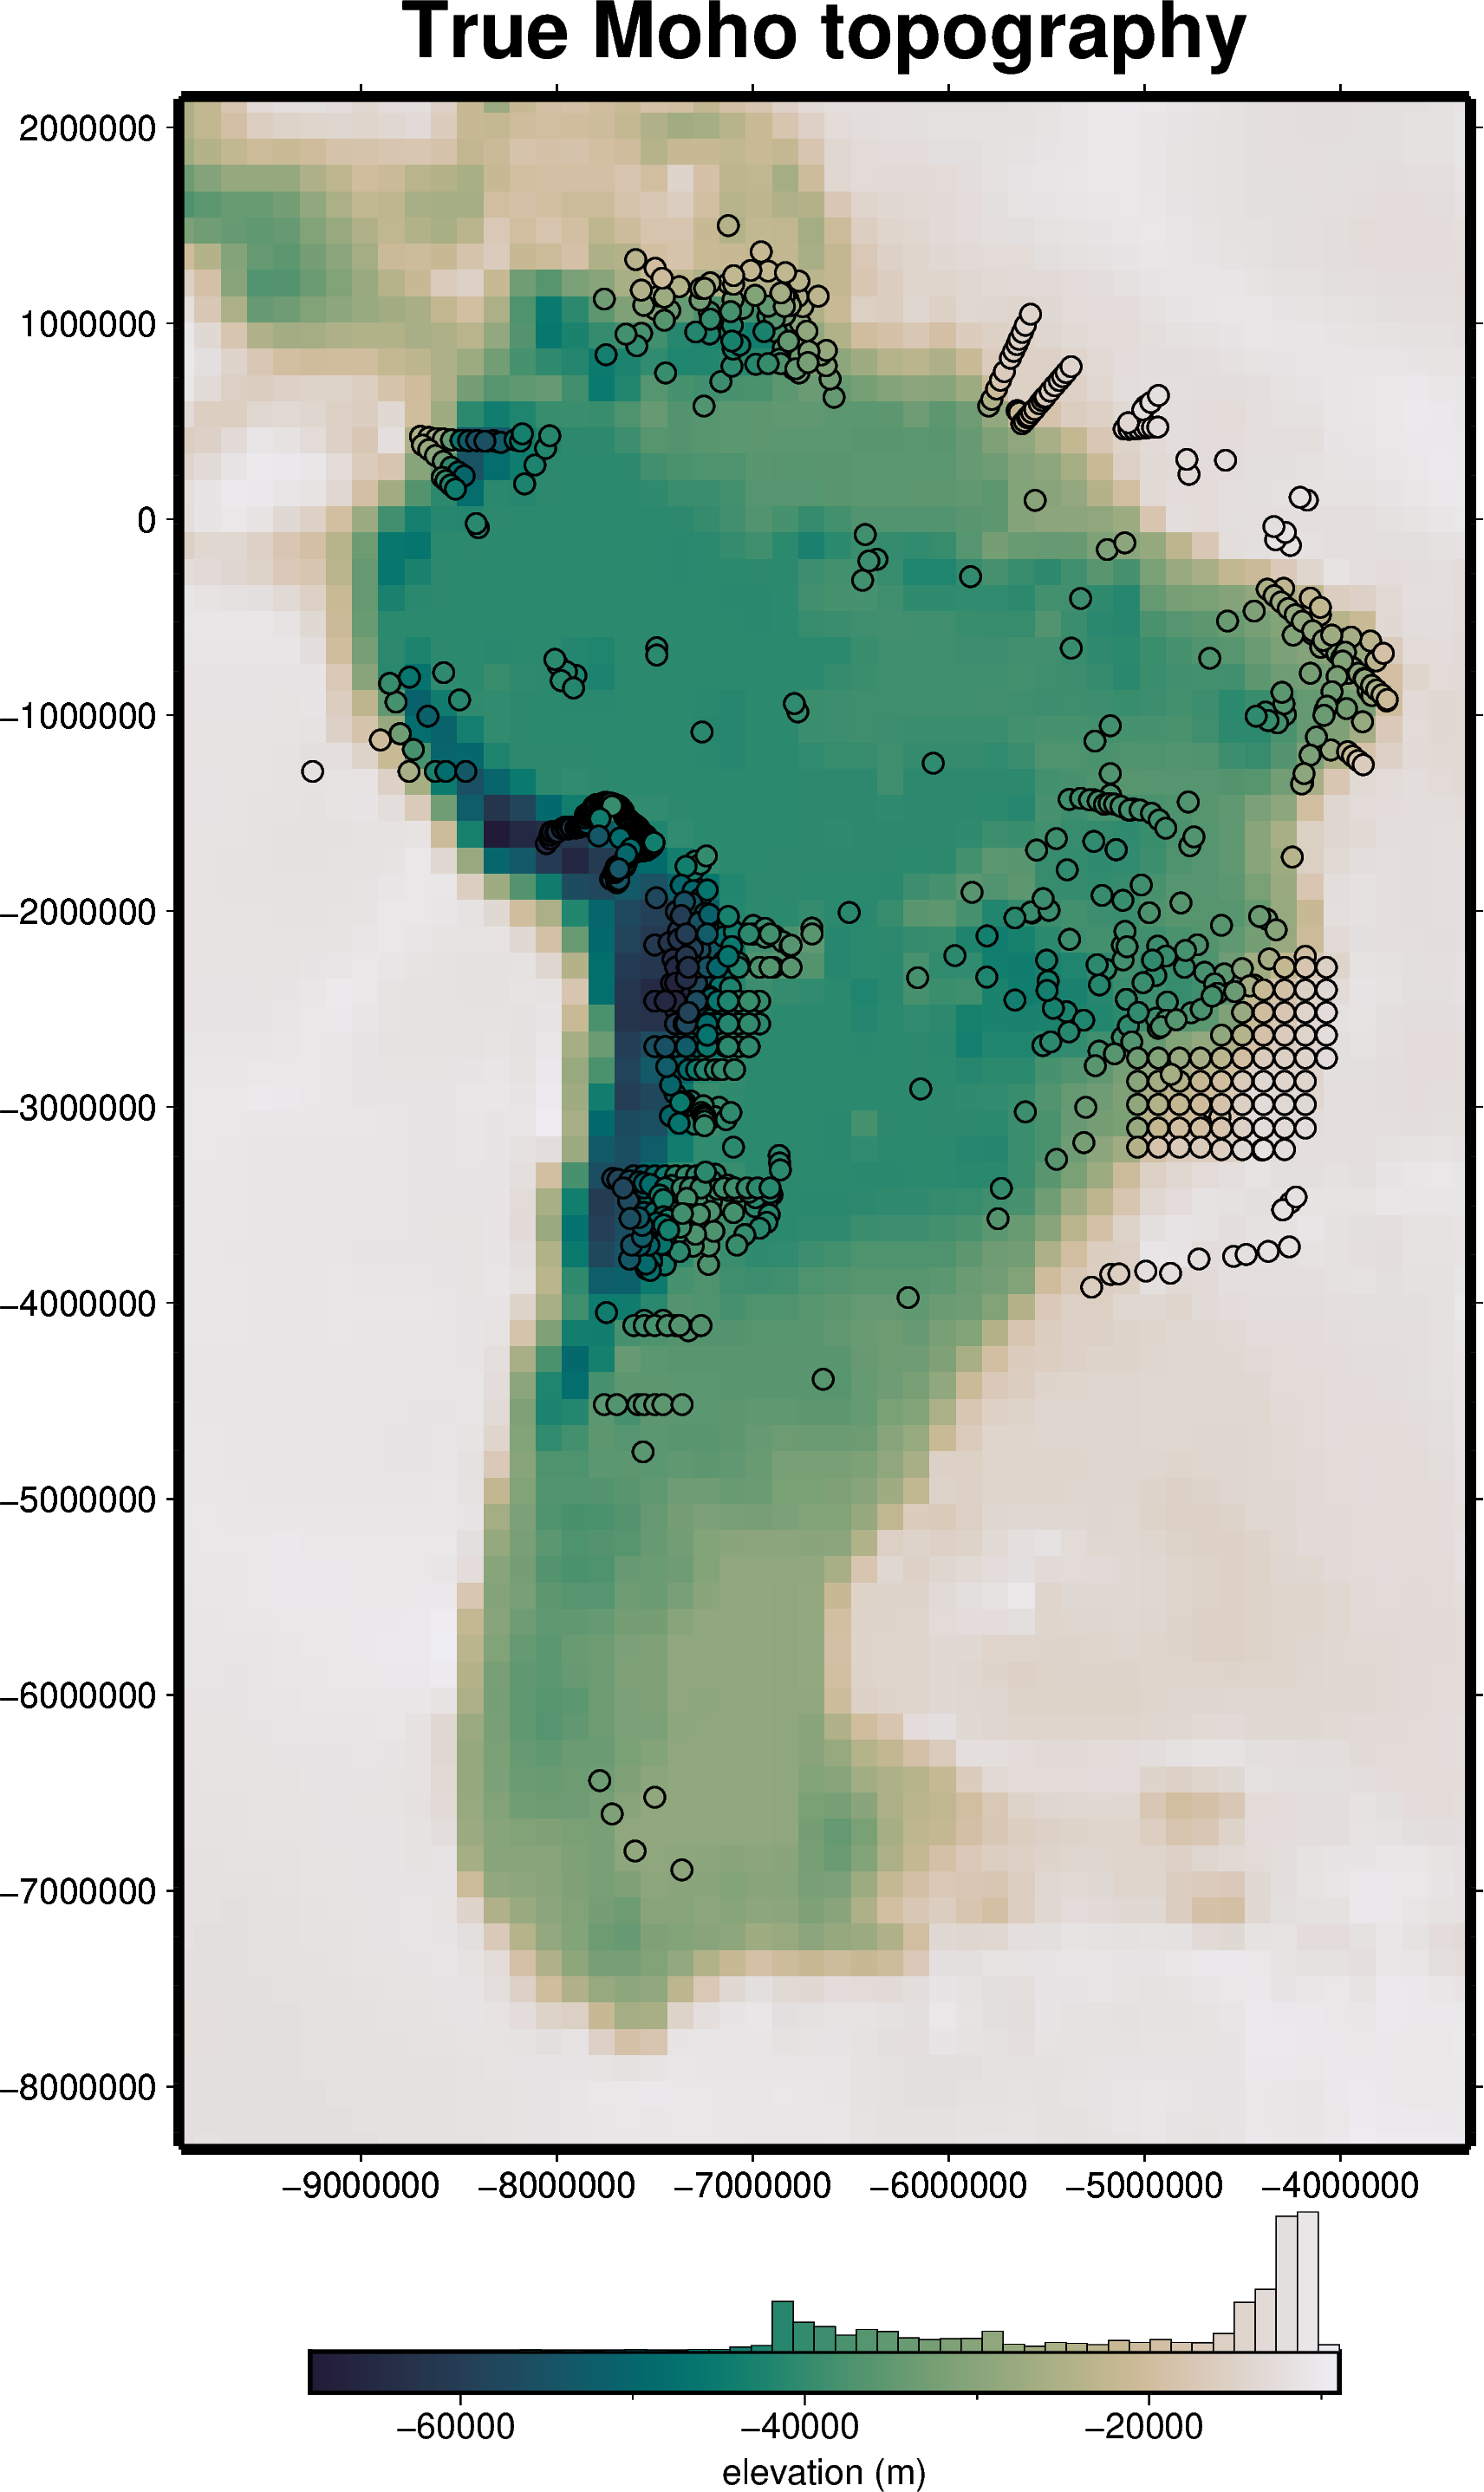

In [6]:
fig = maps.plot_grd(
    true_moho,
    fig_height=20,
    title="True Moho topography",
    hist=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_yoffset=2,
    cbar_label="elevation (m)",
    # robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
# plot seismic points
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="c.2c",
    fill=constraint_points.upward,
    cmap=True,
    pen=".6p,black",
)
fig.show()

# Observed gravity data
We can now forward-model the effects of this topography and add some noise to make a synthetic observed gravity dataset.

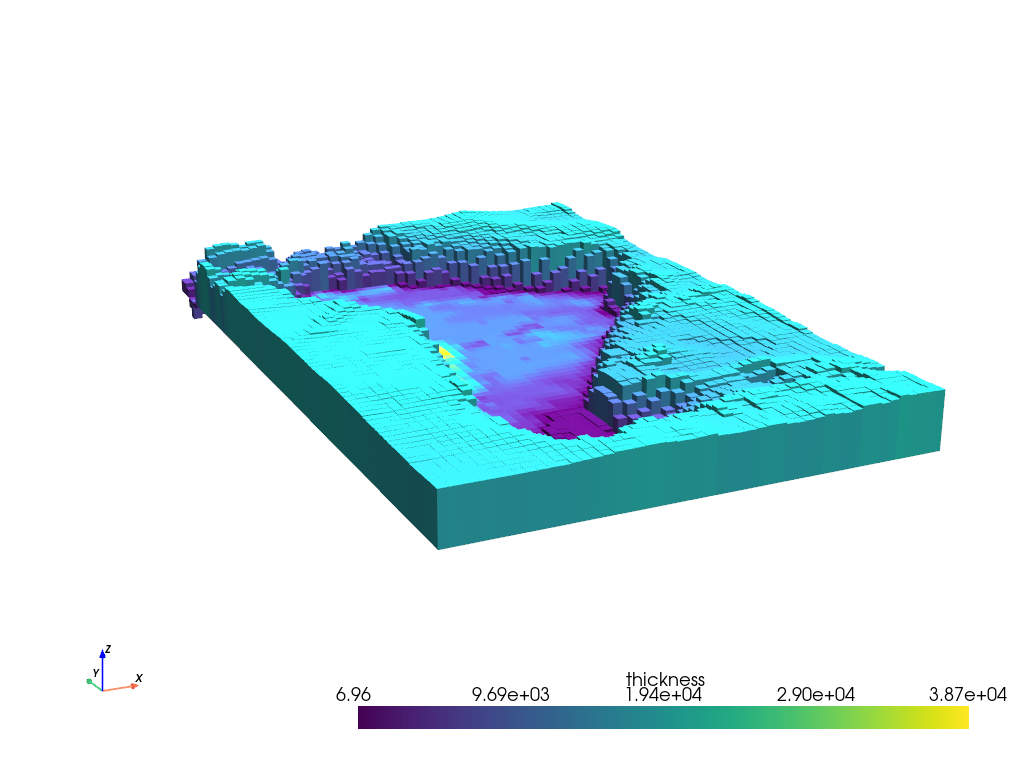

In [7]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 350

# make prism layer
true_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    starting_topography=true_moho.to_dataset(name="upward"),
)

invert4geom.show_prism_layers(
    true_model,
    color_by="thickness",
    # color_by="density",
    log_scale=False,
    zscale=40,
    backend="static",
)

In [9]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

grav_data.inv.forward_gravity(true_model, "gravity_anomaly")

# contaminate gravity with 5 mGal random noise
grav_data["gravity_anomaly"], stddev = invert4geom.contaminate(
    grav_data.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_data

<xarray.Dataset> Size: 64kB
Dimensions:          (northing: 79, easting: 50)
Coordinates:
  * easting          (easting) float64 400B -9.916e+06 -9.782e+06 ... -3.35e+06
  * northing         (northing) float64 632B -8.308e+06 -8.174e+06 ... 2.144e+06
Data variables:
    upward           (northing, easting) float64 32kB 5e+04 5e+04 ... 5e+04
    gravity_anomaly  (northing, easting) float64 32kB 149.7 177.3 ... 158.5
Attributes:
    region:        (-9916000.0, -3350000.0, -8308000.0, 2144000.0)
    spacing:       134000.0
    buffer_width:  670000.0
    inner_region:  (-9246000.0, -4020000.0, -7638000.0, 1474000.0)
    dataset_type:  data
    model_type:    prisms

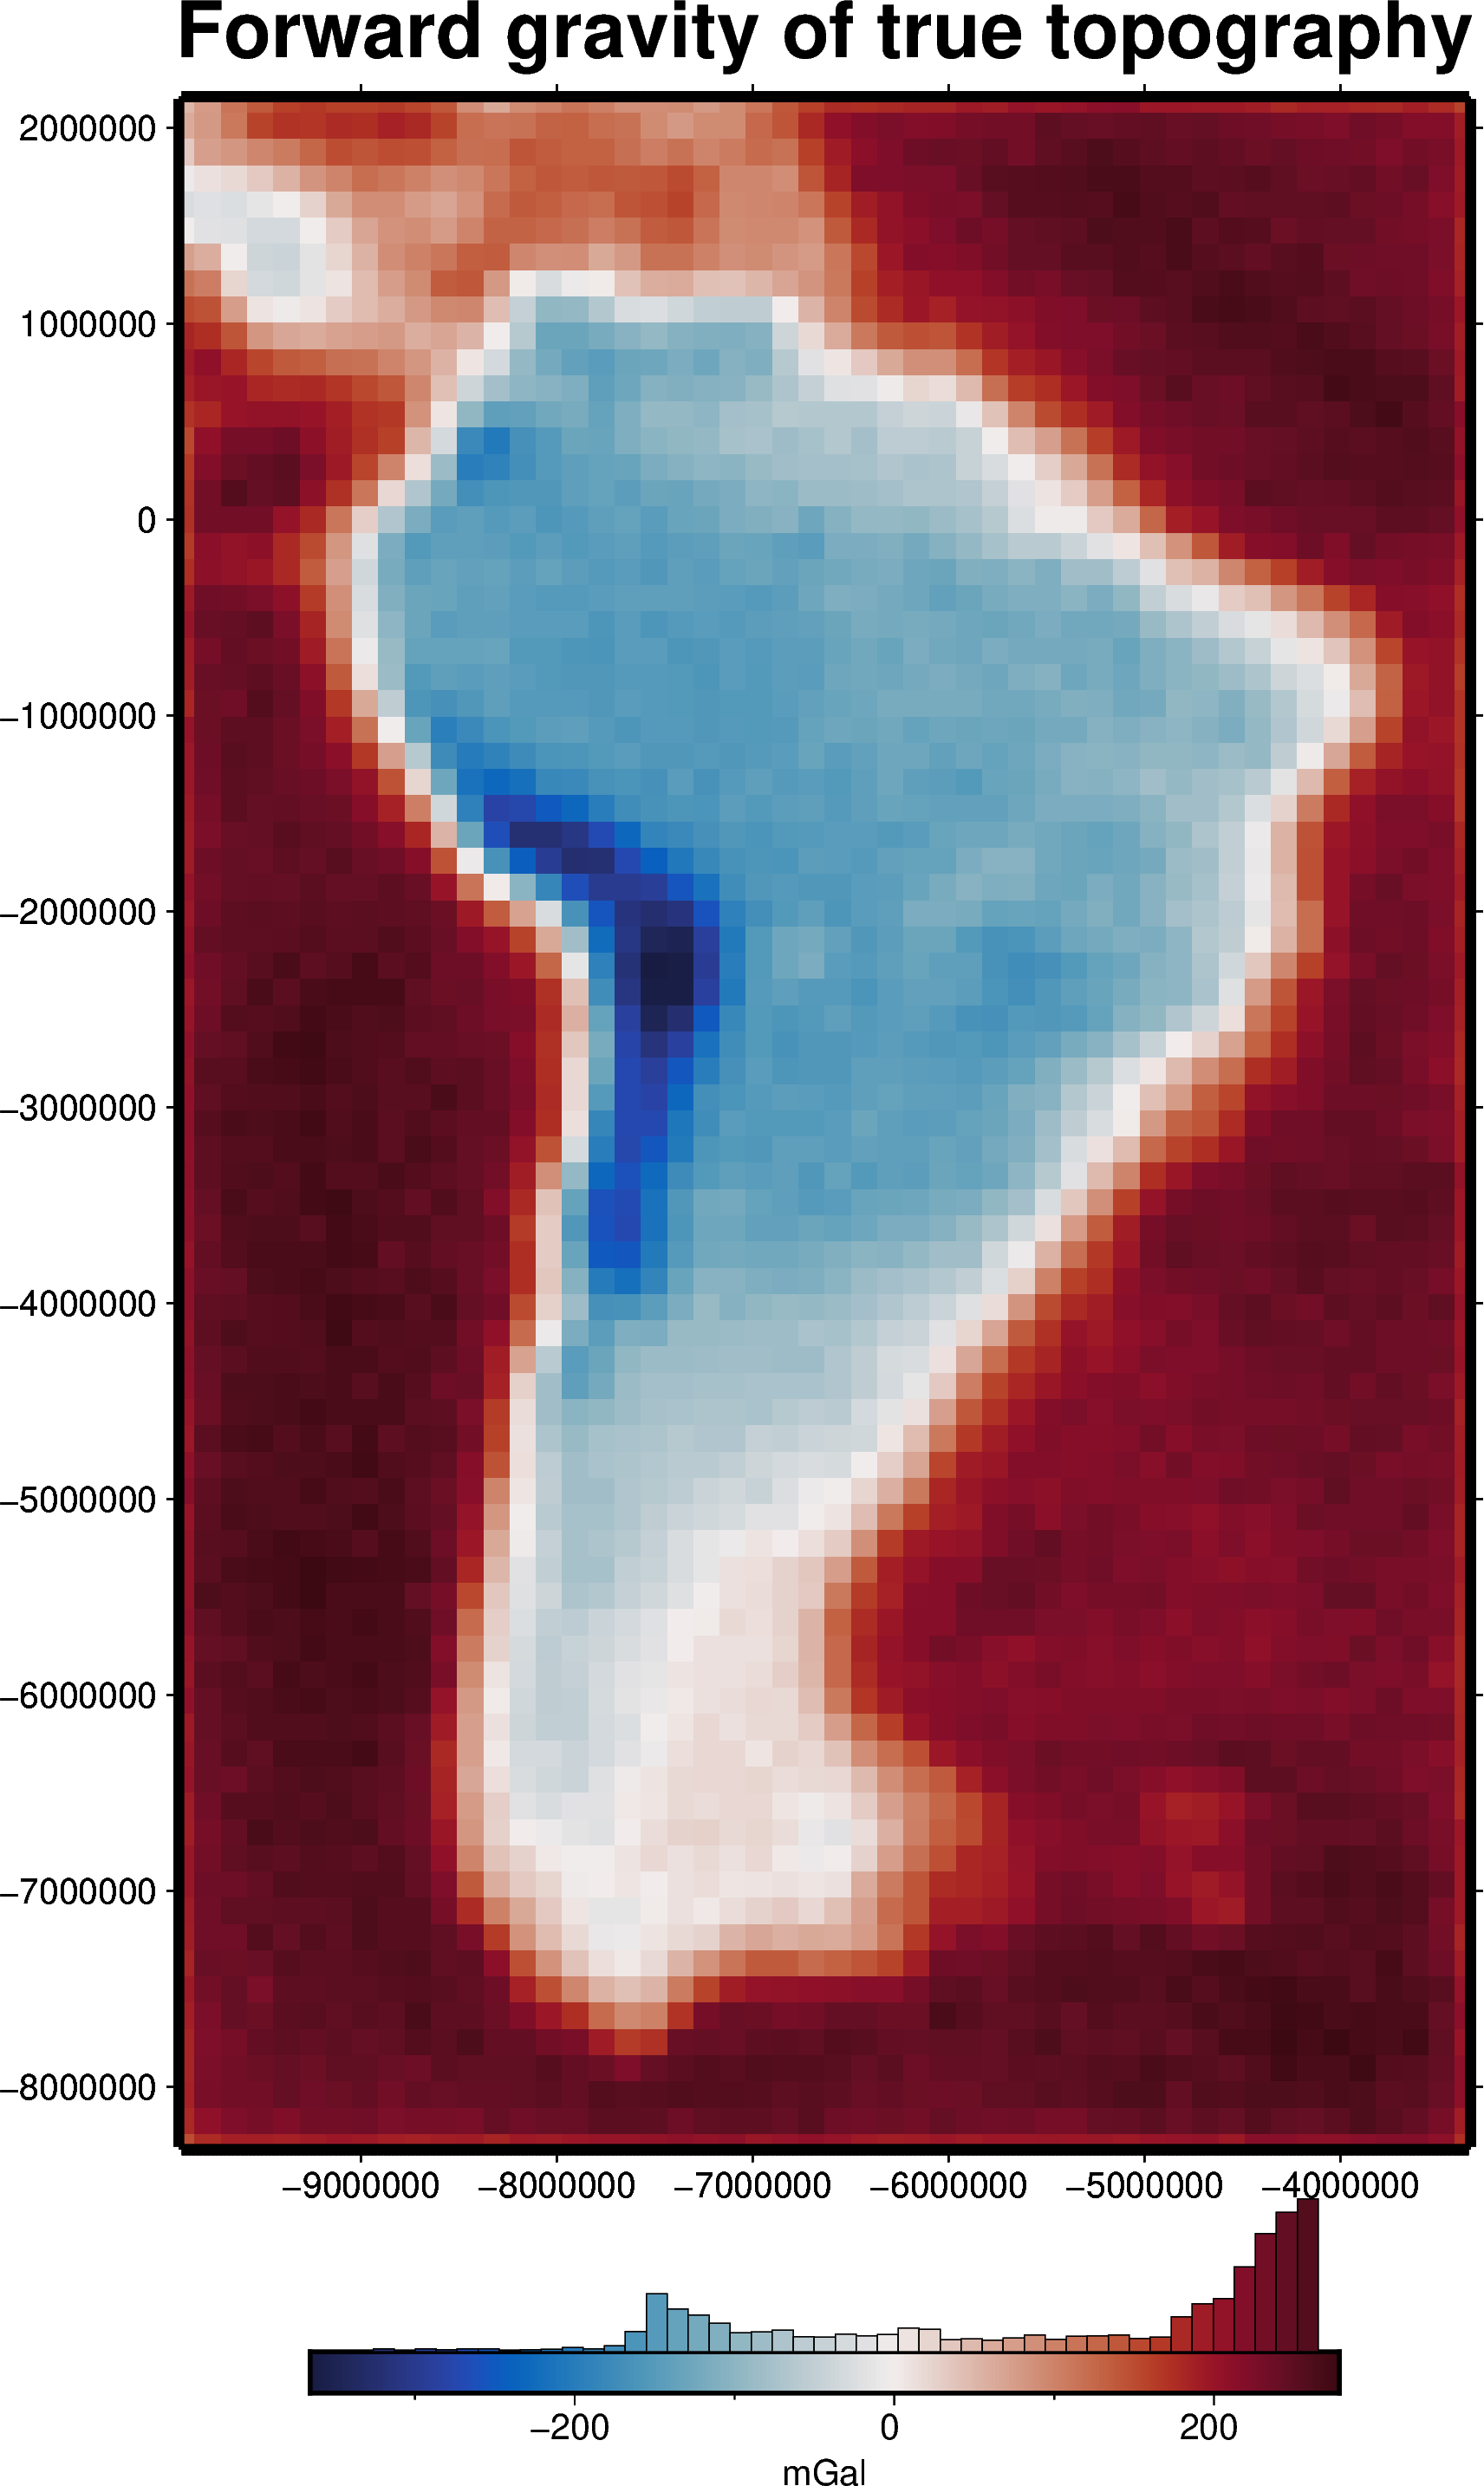

In [10]:
fig = maps.plot_grd(
    grav_data.gravity_anomaly,
    fig_height=20,
    title="Forward gravity of true topography",
    hist=True,
    cbar_yoffset=2,
    cmap="balance+h0",
    cbar_label="mGal",
    # robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

# Starting model
Following the paper's approach, we create a starting model which uses the true values of the density contrast and reference level for the Moho. This is used during the damping parameter cross-validation.

In [11]:
true_zref, true_density_contrast

(-30000.0, 350)

In [12]:
# create flat topography grid with a constant height equal the mean of the starting
# topography (zref)
starting_topography = xr.full_like(true_moho, true_zref).to_dataset(name="upward")

model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    starting_topography=starting_topography,
)

# calculate the forward gravity of the initial model
grav_data.inv.starting_gravity(
    model,
    progressbar=True,
)

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data.inv.df

  0%|          | 0/3950 [00:00<?, ?it/s]

northing    easting   upward  gravity_anomaly  starting_gravity  \
0    -8308000.0 -9916000.0  50000.0       149.729810              -0.0   
1    -8308000.0 -9782000.0  50000.0       177.274516              -0.0   
2    -8308000.0 -9648000.0  50000.0       187.825310              -0.0   
3    -8308000.0 -9514000.0  50000.0       187.905975              -0.0   
4    -8308000.0 -9380000.0  50000.0       186.235470              -0.0   
...         ...        ...      ...              ...               ...   
3945  2144000.0 -3886000.0  50000.0       181.152798              -0.0   
3946  2144000.0 -3752000.0  50000.0       179.750517              -0.0   
3947  2144000.0 -3618000.0  50000.0       187.116664              -0.0   
3948  2144000.0 -3484000.0  50000.0       176.897510              -0.0   
3949  2144000.0 -3350000.0  50000.0       158.524281              -0.0   

      forward_gravity      misfit  reg         res  starting_forward_gravity  \
0                -0.0  149.729810  0.0  149.729810                      -0.0   
1                -0.0  177.274516  0.0  177.274516                      -0.0   
2                -0.0  187.825310  0.0  187.825310                      -0.0   
3                -0.0  187.905975  0.0  187.905975                      -0.0   
4                -0.0  186.235470  0.0  186.235470                      -0.0   
...               ...         ...  ...         ...                       ...   
3945             -0.0  181.152798  0.0  181.152798                      -0.0   
3946             -0.0  179.750517  0.0  179.750517                      -0.0   
3947             -0.0  187.116664  0.0  187.116664                      -0.0   
3948             -0.0  176.897510  0.0  176.897510                      -0.0   
3949             -0.0  158.524281  0.0  158.524281                      -0.0   

      starting_misfit  starting_reg  starting_res  
0          149.729810           0.0    149.729810  
1          177.274516           0.0    177.274516  
2          187.825310           0.0    187.825310  
3          187.905975           0.0    187.905975  
4          186.235470           0.0    186.235470  
...               ...           ...           ...  
3945       181.152798           0.0    181.152798  
3946       179.750517           0.0    179.750517  
3947       187.116664           0.0    187.116664  
3948       176.897510           0.0    176.897510  
3949       158.524281           0.0    158.524281  

[3950 rows x 13 columns]

# Damping parameter cross validation

## Get individual score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

In [13]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.01,
    # set stopping criteria
    max_iterations=300,
    l2_norm_tolerance=2.2,  # gravity error is 5 mGal or L2-norm of ~2.2
    delta_l2_norm_tolerance=1.008,
)

In [14]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)
inv.data.inv.df

northing    easting   test   upward  gravity_anomaly  \
0     -8308000.0 -9916000.0  False  50000.0       149.729813   
1     -8308000.0 -9849000.0   True  50000.0       164.564286   
2     -8308000.0 -9782000.0  False  50000.0       177.274521   
3     -8308000.0 -9715000.0   True  50000.0       184.266422   
4     -8308000.0 -9648000.0  False  50000.0       187.825317   
...          ...        ...    ...      ...              ...   
15538  2144000.0 -3618000.0  False  50000.0       187.116669   
15539  2144000.0 -3551000.0   True  50000.0       183.615799   
15540  2144000.0 -3484000.0  False  50000.0       176.897507   
15541  2144000.0 -3417000.0   True  50000.0       168.220521   
15542  2144000.0 -3350000.0  False  50000.0       158.524277   

       starting_gravity  forward_gravity      misfit  reg         res  \
0                   0.0              0.0  149.729813  0.0  149.729813   
1                   0.0              0.0  164.564286  0.0  164.564286   
2                   0.0              0.0  177.274521  0.0  177.274521   
3                   0.0              0.0  184.266422  0.0  184.266422   
4                   0.0              0.0  187.825317  0.0  187.825317   
...                 ...              ...         ...  ...         ...   
15538               0.0              0.0  187.116669  0.0  187.116669   
15539               0.0              0.0  183.615799  0.0  183.615799   
15540               0.0              0.0  176.897507  0.0  176.897507   
15541               0.0              0.0  168.220521  0.0  168.220521   
15542               0.0              0.0  158.524277  0.0  158.524277   

       starting_forward_gravity  starting_misfit  starting_reg  starting_res  
0                           0.0       149.729813           0.0    149.729813  
1                           0.0       164.564286           0.0    164.564286  
2                           0.0       177.274521           0.0    177.274521  
3                           0.0       184.266422           0.0    184.266422  
4                           0.0       187.825317           0.0    187.825317  
...                         ...              ...           ...           ...  
15538                       0.0       187.116669           0.0    187.116669  
15539                       0.0       183.615799           0.0    183.615799  
15540                       0.0       176.897507           0.0    176.897507  
15541                       0.0       168.220521           0.0    168.220521  
15542                       0.0       158.524277           0.0    158.524277  

[15543 rows x 14 columns]

In [15]:
inv.model

<xarray.Dataset> Size: 222kB
Dimensions:                (northing: 79, easting: 50)
Coordinates:
  * easting                (easting) float64 400B -9.916e+06 ... -3.35e+06
  * northing               (northing) float64 632B -8.308e+06 ... 2.144e+06
    top                    (northing, easting) float32 16kB -3e+04 ... -3e+04
    bottom                 (northing, easting) float64 32kB -3e+04 ... -3e+04
Data variables:
    density                (northing, easting) int64 32kB 350 350 ... 350 350
    thickness              (northing, easting) float64 32kB 0.0 0.0 ... 0.0 0.0
    starting_topography    (northing, easting) float32 16kB -3e+04 ... -3e+04
    topography             (northing, easting) float32 16kB -3e+04 ... -3e+04
    mask                   (northing, easting) float32 16kB 1.0 1.0 ... 1.0 1.0
    upper_confining_layer  (northing, easting) float64 32kB nan nan ... nan nan
    lower_confining_layer  (northing, easting) float64 32kB nan nan ... nan nan
Attributes:
    inner_region:      (-9916000.0, -3350000.0, -8308000.0, 2144000.0)
    zref:              -30000.0
    density_contrast:  350
    region:            (-9916000.0, -3350000.0, -8308000.0, 2144000.0)
    spacing:           134000.0
    dataset_type:      model
    model_type:        prisms

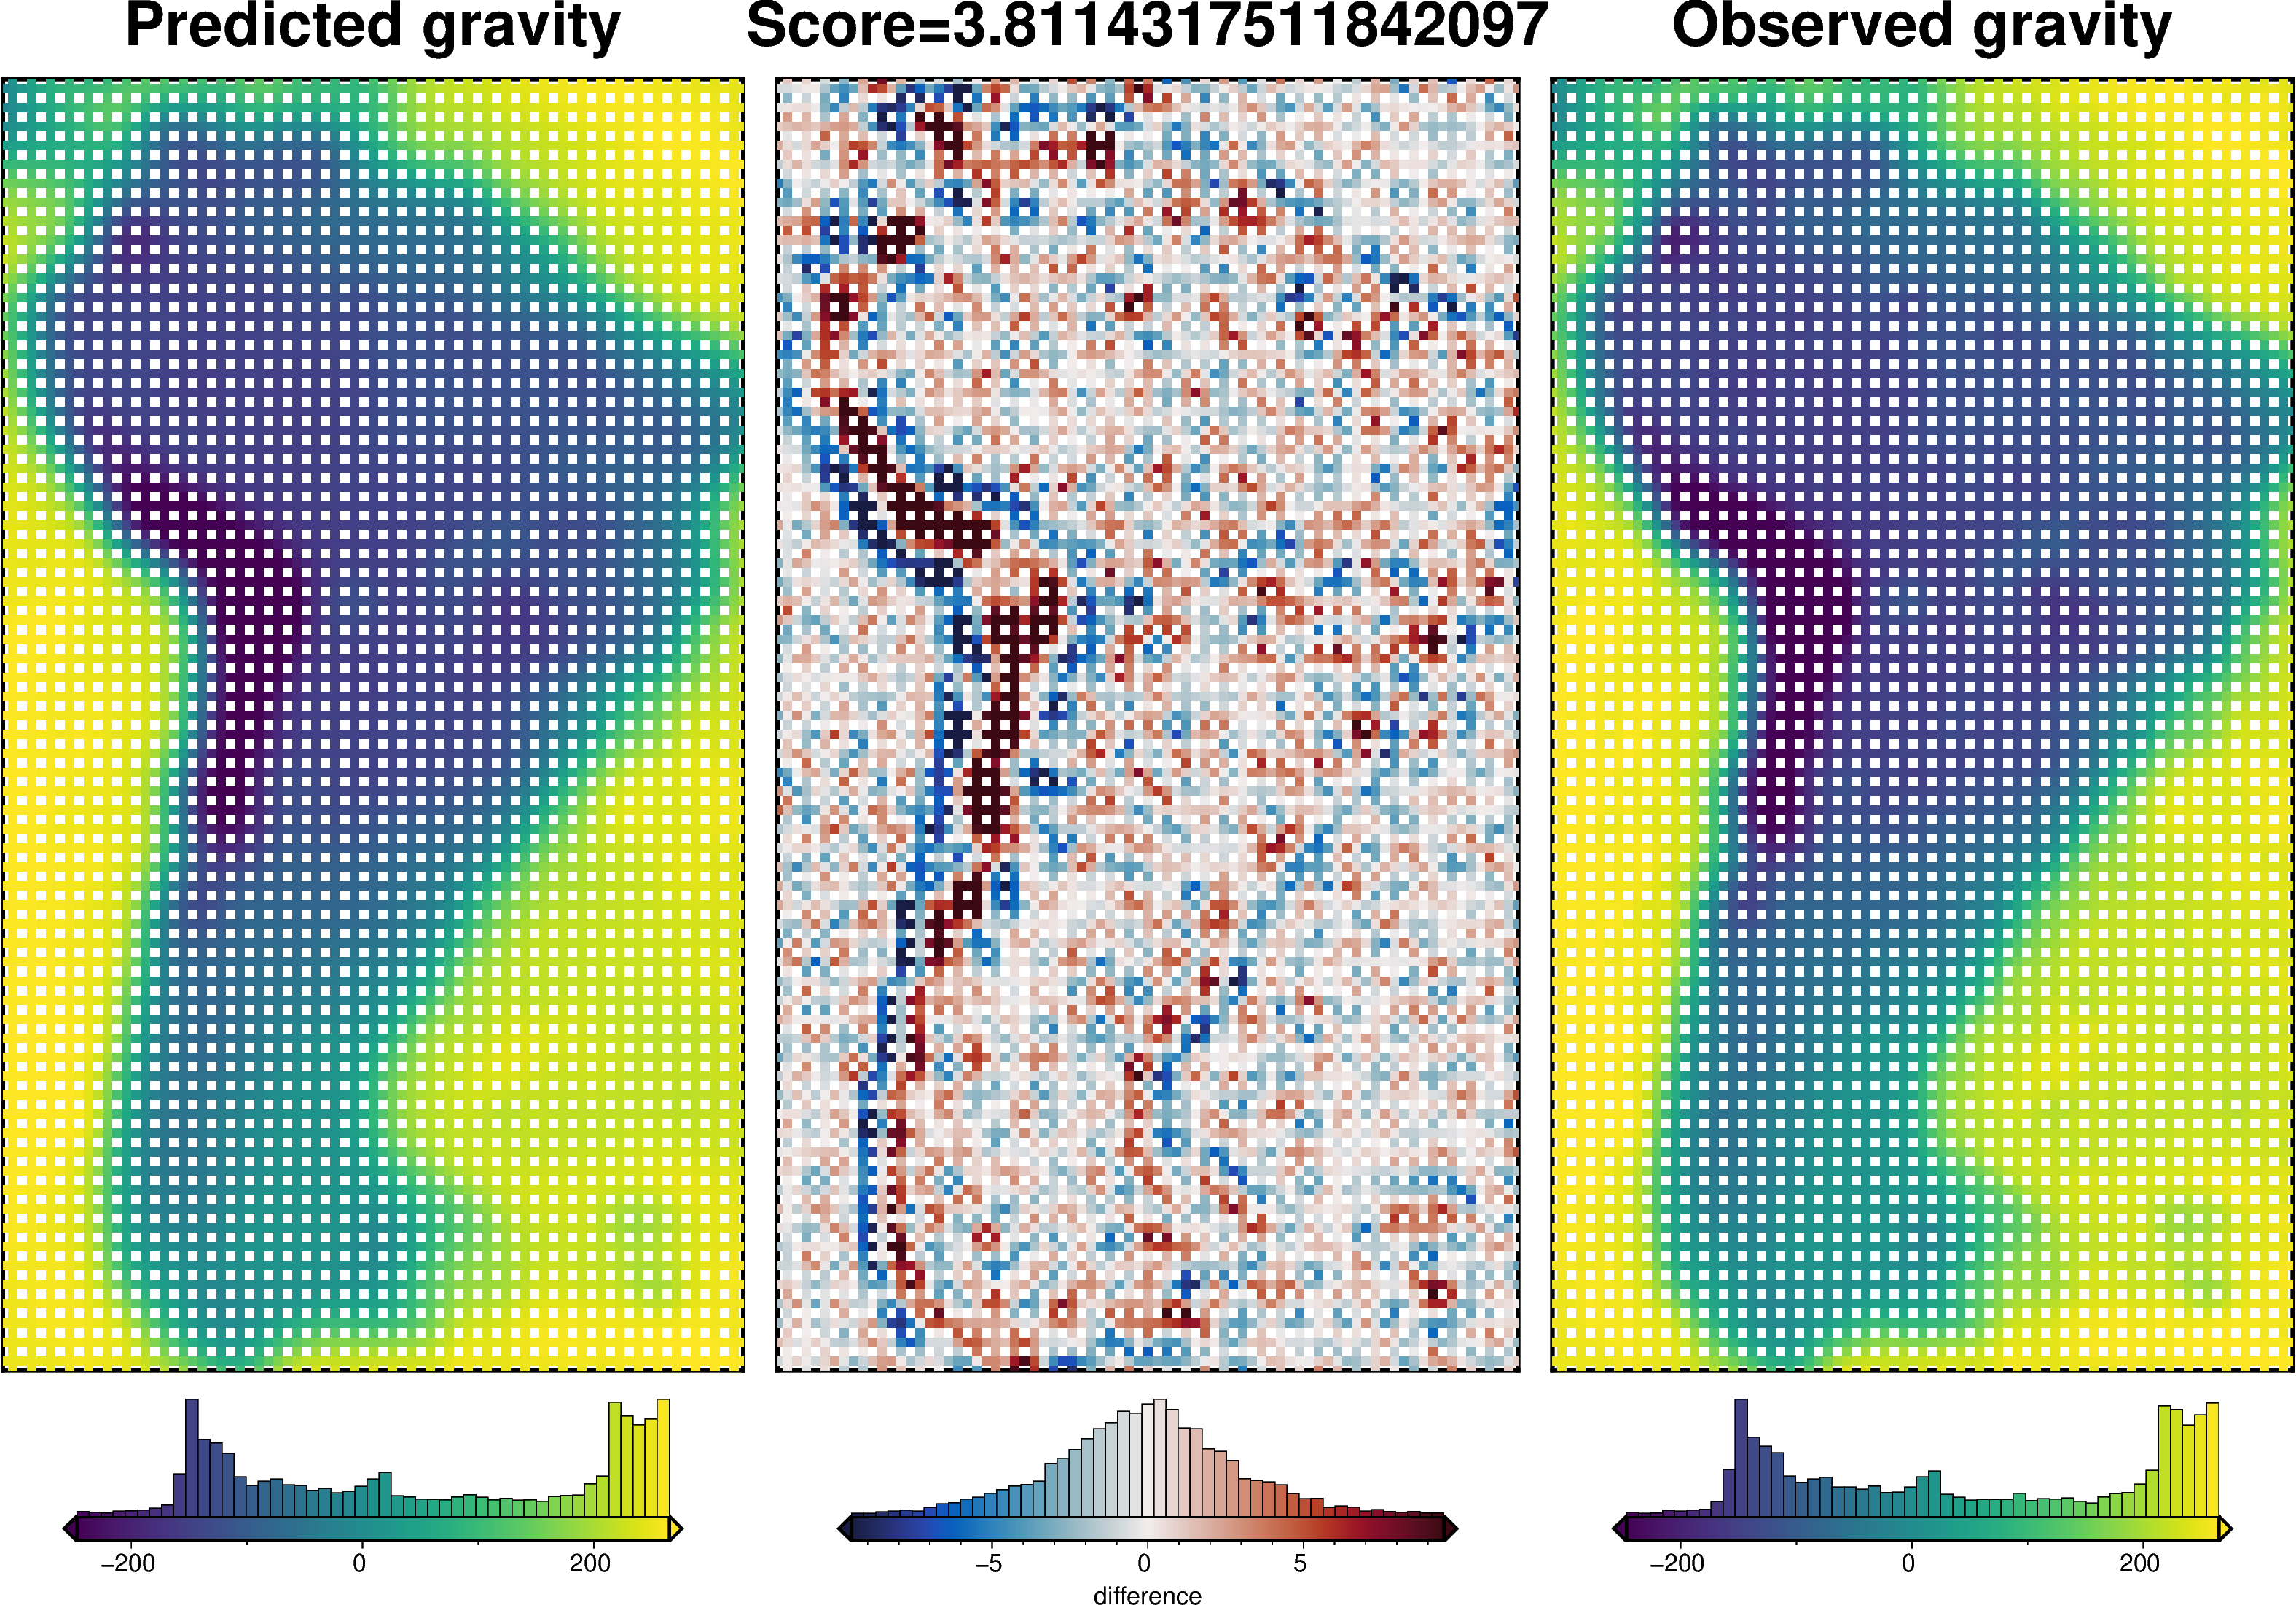

np.float64(3.8114317511842097)

In [16]:
# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
grav_cv_object = inv.grav_cv_score(
    plot=True,
)
inv.gravity_cv_best_score

## Cross Validation Optimization

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.002696249208140381

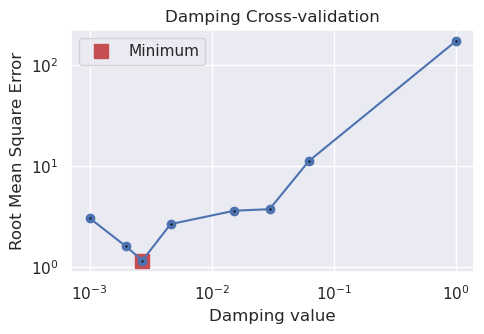

In [17]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    plot_cv=True,
    fname="../tmp/uieda_CRUST1_damping_CV",
)
inv.solver_damping

In [18]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [19]:
study.trials_dataframe().sort_values("value")

number       value             datetime_start          datetime_complete  \
7       7    1.161597 2025-10-07 17:03:27.826875 2025-10-07 17:03:43.988157   
2       2    1.604859 2025-10-07 16:52:02.137511 2025-10-07 16:52:18.688250   
6       6    2.666323 2025-10-07 17:03:10.683349 2025-10-07 17:03:27.819645   
0       0    3.047871 2025-10-07 16:51:31.725127 2025-10-07 16:51:49.587323   
4       4    3.618257 2025-10-07 16:58:29.557491 2025-10-07 16:59:42.060255   
5       5    3.748855 2025-10-07 16:59:42.068749 2025-10-07 17:03:10.659465   
3       3   11.264384 2025-10-07 16:52:18.692460 2025-10-07 16:58:29.518126   
1       1  172.000371 2025-10-07 16:51:49.589911 2025-10-07 16:52:02.135407   

                duration  params_damping  \
7 0 days 00:00:16.161282        0.002696   
2 0 days 00:00:16.550739        0.001983   
6 0 days 00:00:17.136296        0.004597   
0 0 days 00:00:17.862196        0.001000   
4 0 days 00:01:12.502764        0.015284   
5 0 days 00:03:28.590716        0.029769   
3 0 days 00:06:10.825666        0.062714   
1 0 days 00:00:12.545496        1.000000   

                         user_attrs_fname system_attrs_fixed_params     state  
7  ../tmp/uieda_CRUST1_damping_CV_trial_7                       NaN  COMPLETE  
2  ../tmp/uieda_CRUST1_damping_CV_trial_2                       NaN  COMPLETE  
6  ../tmp/uieda_CRUST1_damping_CV_trial_6                       NaN  COMPLETE  
0  ../tmp/uieda_CRUST1_damping_CV_trial_0        {'damping': 0.001}  COMPLETE  
4  ../tmp/uieda_CRUST1_damping_CV_trial_4                       NaN  COMPLETE  
5  ../tmp/uieda_CRUST1_damping_CV_trial_5                       NaN  COMPLETE  
3  ../tmp/uieda_CRUST1_damping_CV_trial_3                       NaN  COMPLETE  
1  ../tmp/uieda_CRUST1_damping_CV_trial_1            {'damping': 1}  COMPLETE

The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 7a in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

## Plot results

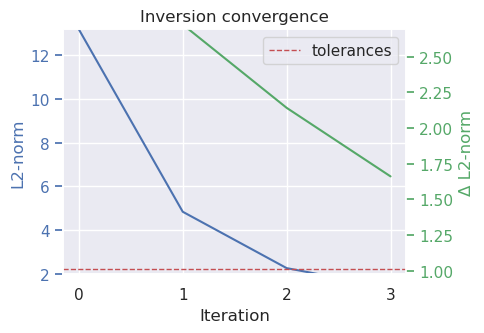

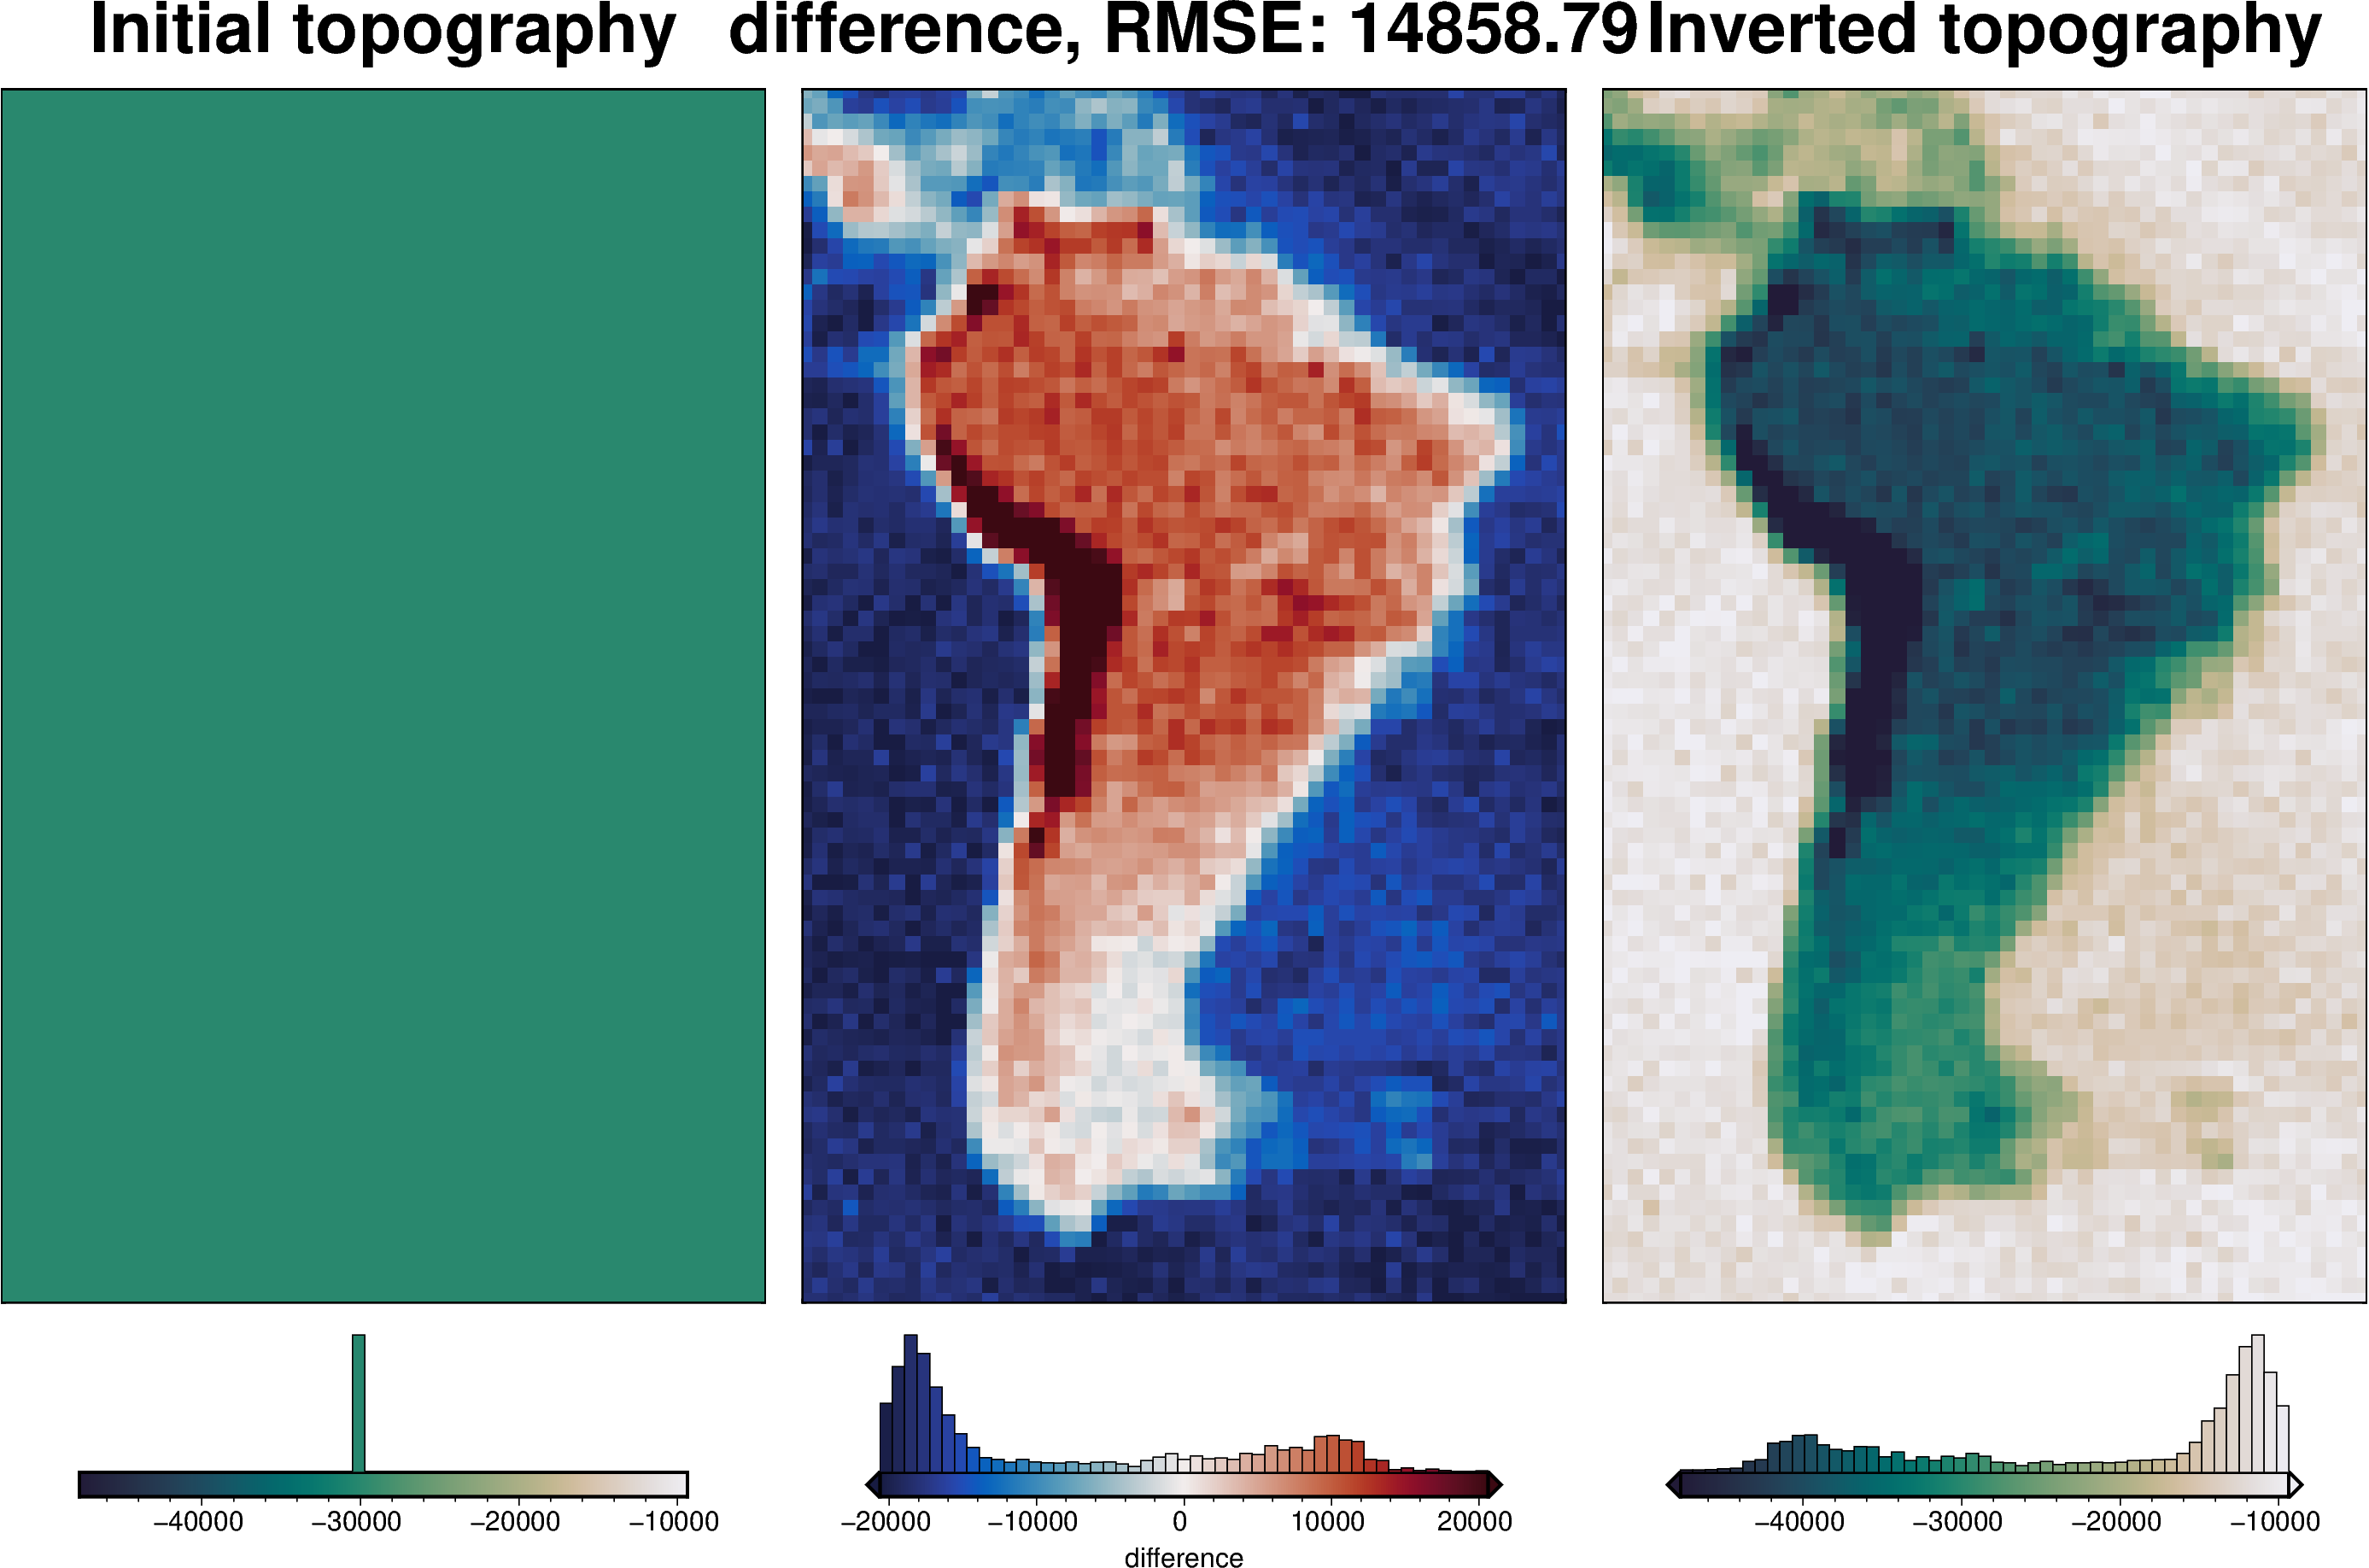

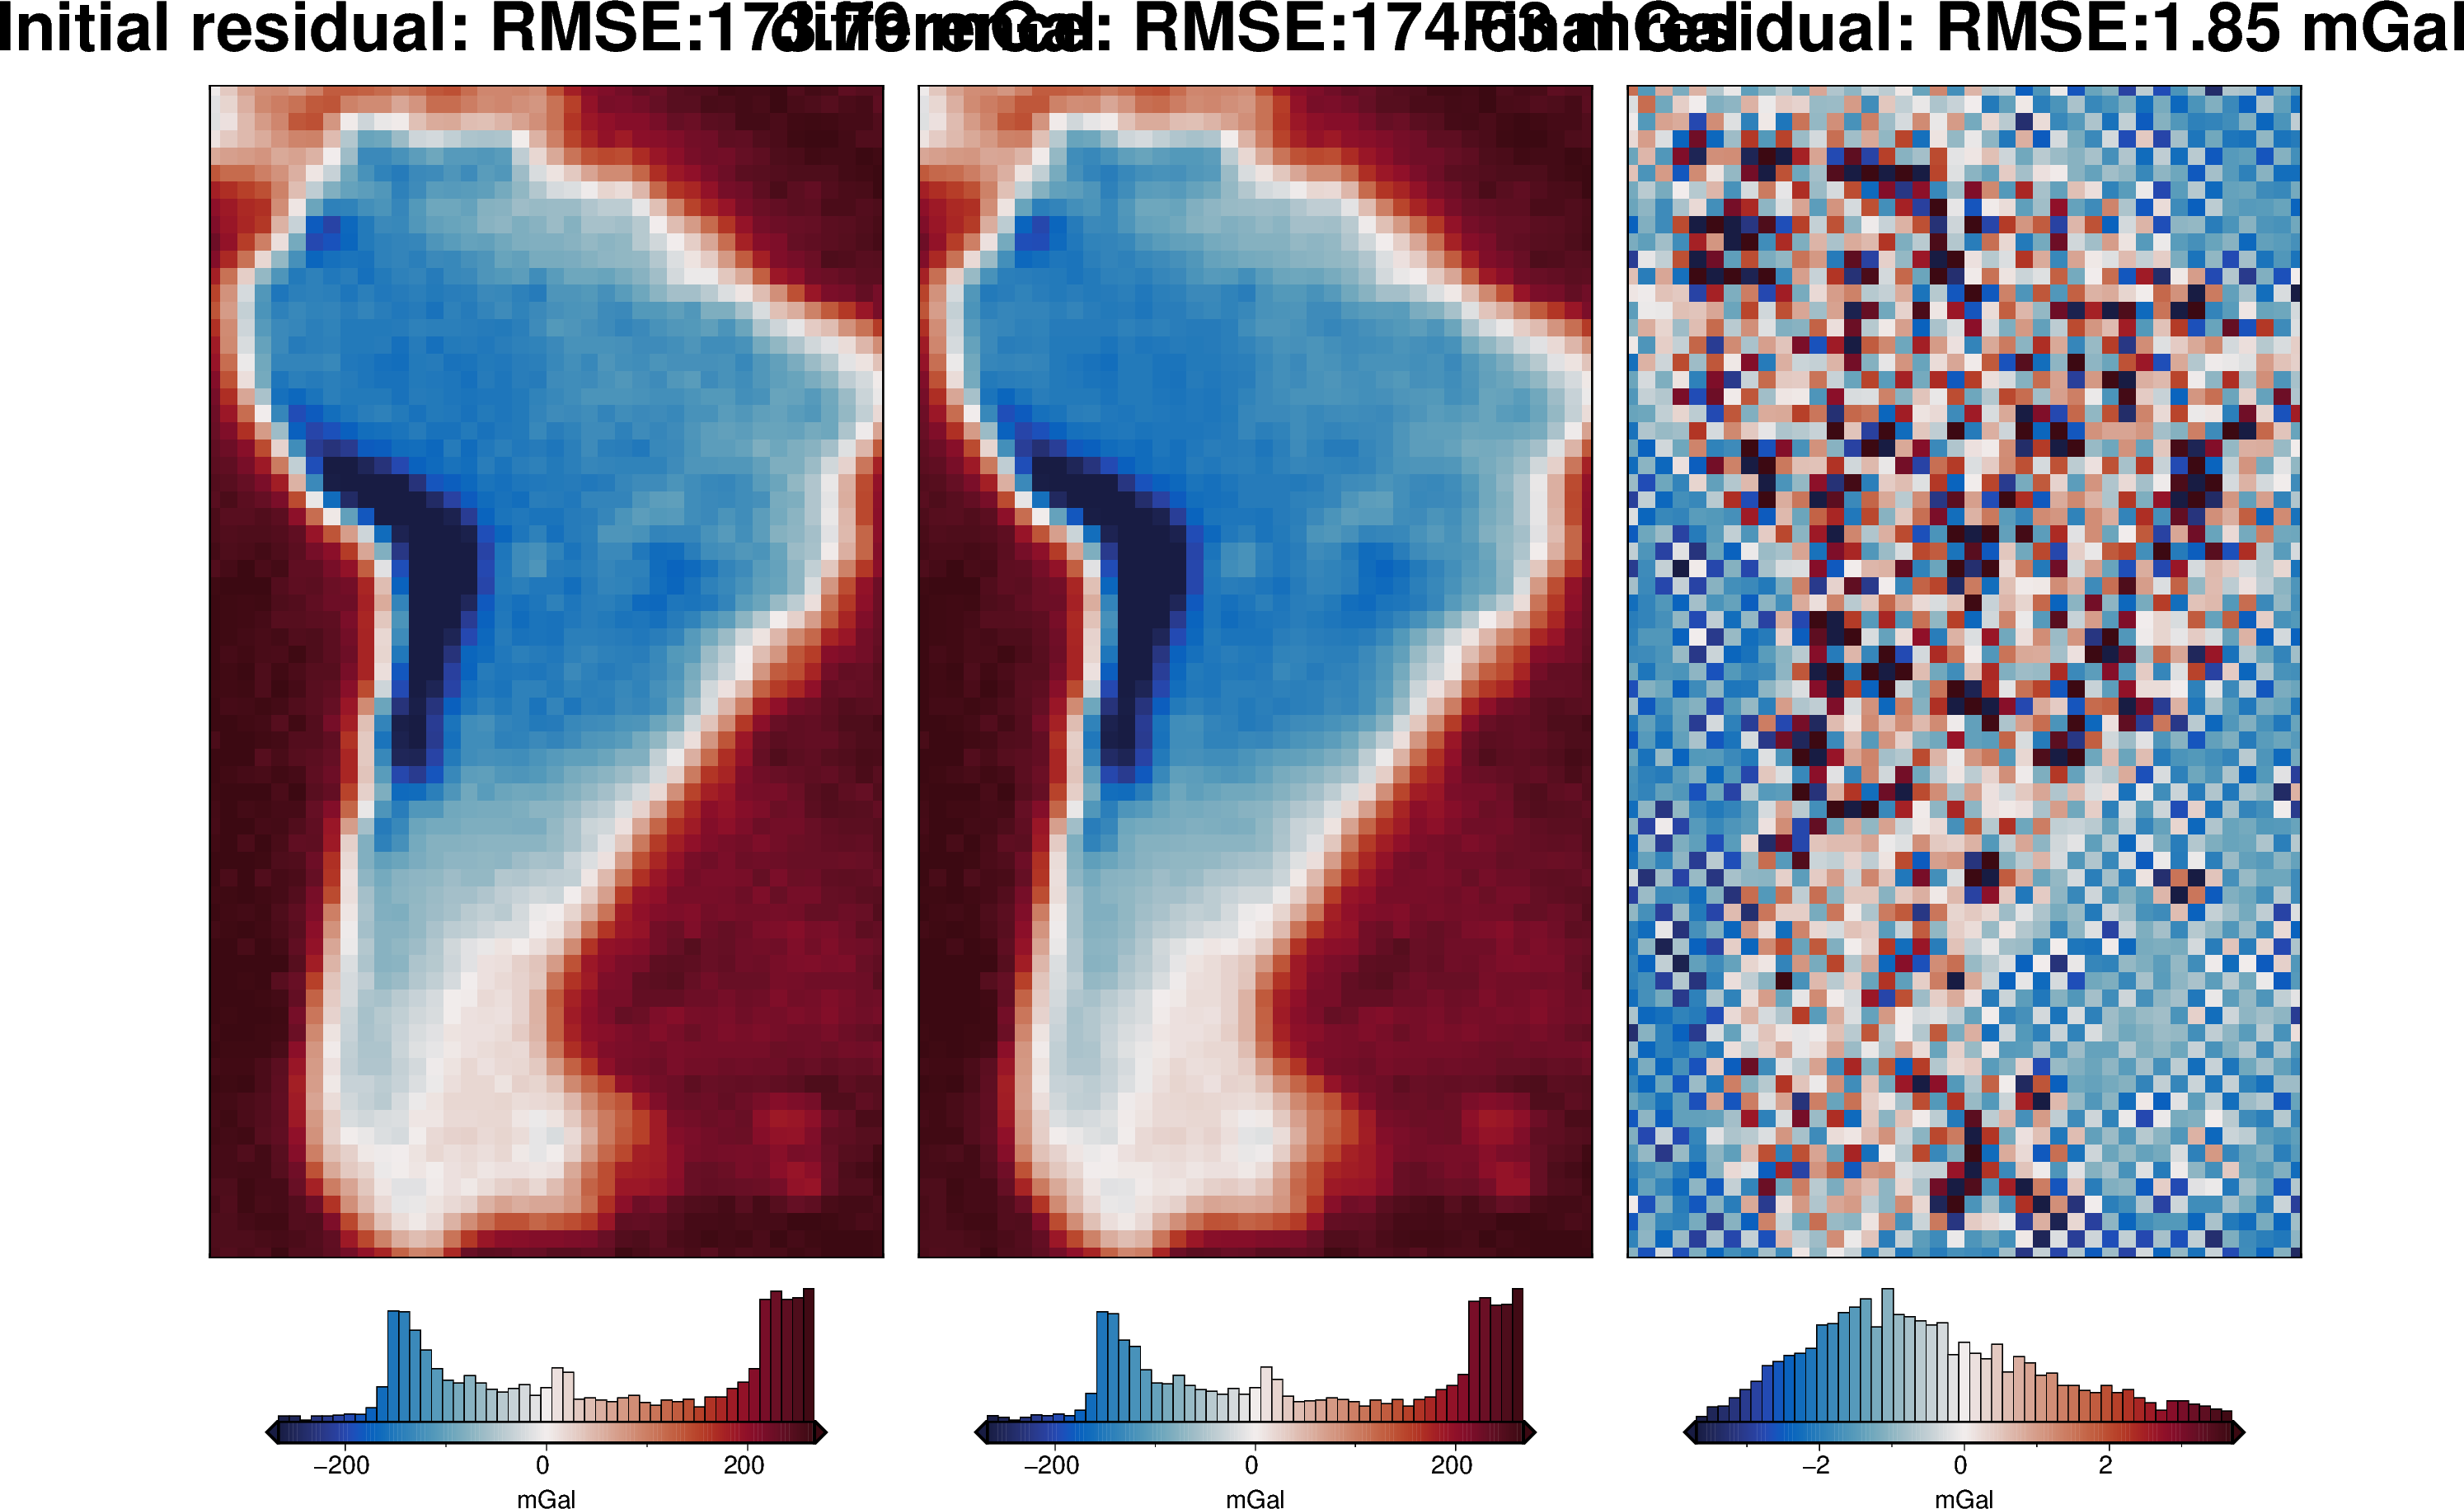

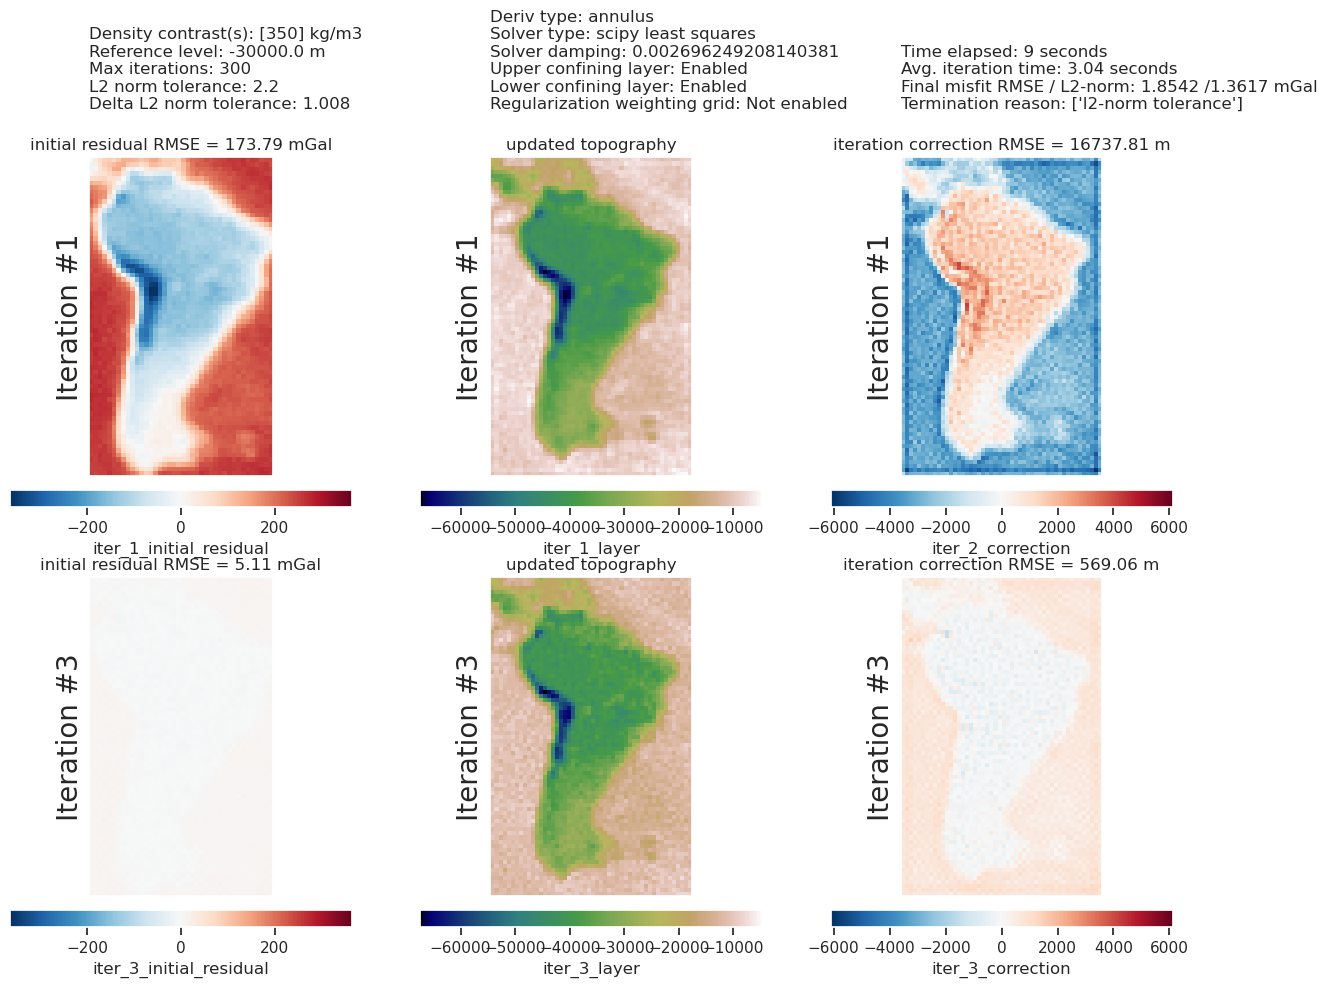

In [20]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

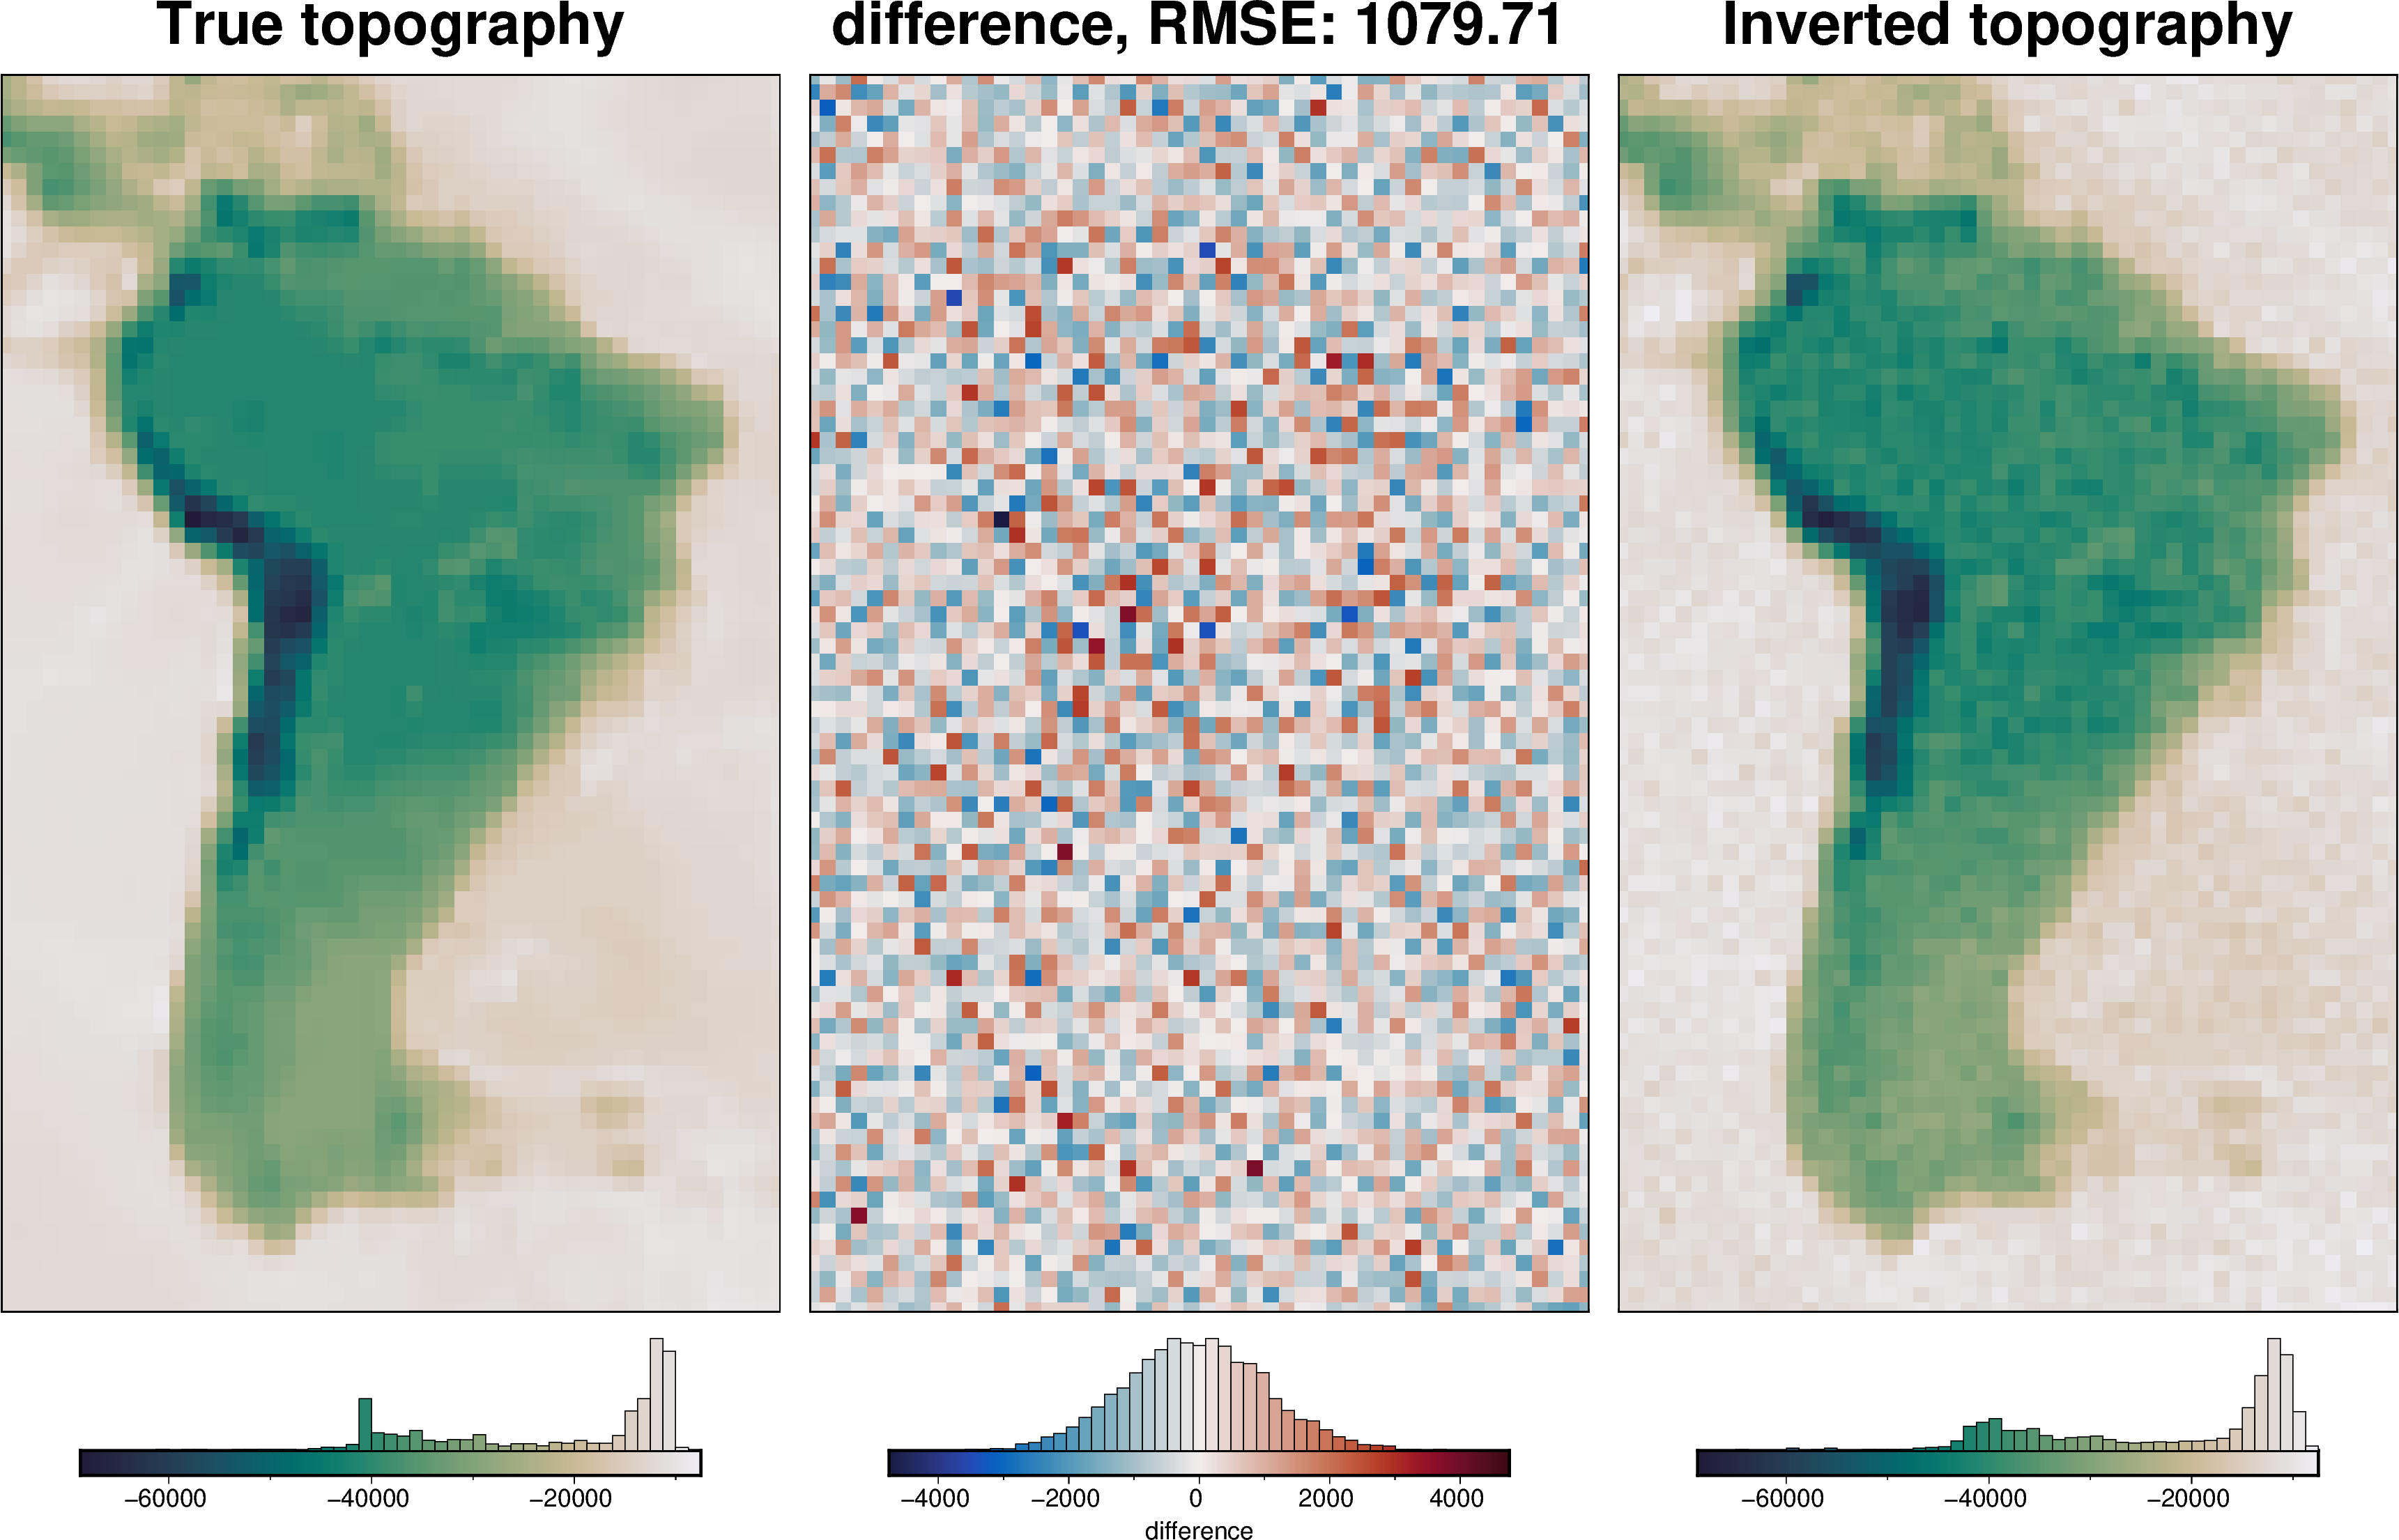

In [21]:
_ = polar_utils.grd_compare(
    true_moho,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

In [22]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 1056.70 m


# Density / Reference level cross validation

Now that we have a optimal damping value, we can perform a cross-validation to find the optimal values for density contrast and reference level. For these, we pick a range of possible values, and perform a hyperparameter optimization to find the best set of values.

In [23]:
# we don't need the testing points anymore
inv.data = invert4geom.remove_test_points(inv.data)

In [24]:
inv.reinitialize_inversion()

In [25]:
# run the cross validation for the zref and density
density_zref_cv_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    density_contrast_limits=(200, 500),
    zref_limits=(-35e3, -20e3),
    n_trials=20,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography_kwargs=dict(
        method="flat",
        region=region,
        spacing=spacing,
    ),
    plot_cv=False,
    fname="../tmp/uieda_CRUST1_zref_density_cv",
)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

'starting_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True
'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [26]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_zref_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

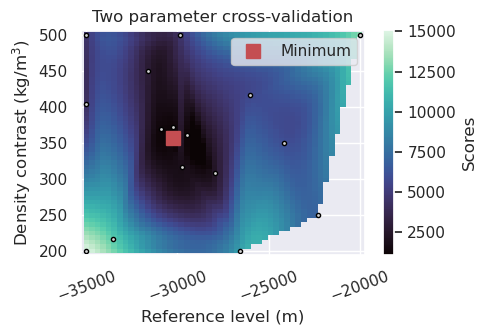

In [27]:
fig = invert4geom.plot_2_parameter_cv_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

In [28]:
best_zref = study.best_params.get("zref")
best_density_contrast = study.best_params.get("density_contrast")

print(f"Optimal zref: {best_zref / 1e3:.1f} km")
print(f"True zref: {true_zref / 1e3:.1f} km")
print(f"Optimal density contrast: {best_density_contrast:.1f} kg/m³")
print(f"True density contrast: {true_density_contrast:.1f} kg/m³")

Optimal zref: -30.2 km
True zref: -30.0 km
Optimal density contrast: 357.0 kg/m³
True density contrast: 350.0 kg/m³


In [29]:
# we can also access the optimally-determined values through the `inv` object
print(f"Solver damping: {inv.solver_damping}")
print(f"Zref: {inv.model.zref / 1e3:.1f} km")
print(f"Density contrast: {inv.model.density_contrast:.1f} kg/m³")

Solver damping: 0.002696249208140381
Zref: -30.2 km
Density contrast: 357.0 kg/m³


The above plot shows the results of the cross validation and is equivalent to Figure 7b in the paper. The optimal values they report are zref = 30 km and density contrast = 350 kg/m-3, which are roughly the same as the values we find. The main difference is that they used a grid-search approach, testing evenly-spaced values between -35 and -20 km, and between 500 and 200 kg/m-3. We instead used an optimization approach, where the parameters space is smartly searched based on the scores of the past trials. As you can see, this allows us to find the optimal values in far fewer trials. Here we used 20 trials, compared to the 49 trials used in the paper.

We also support the grid-search approach, which can be enabled with `grid_search=True` in the above function.

## Plot results

The below plots show the inversion results used the optimal damping, density contrast, and reference level values. 

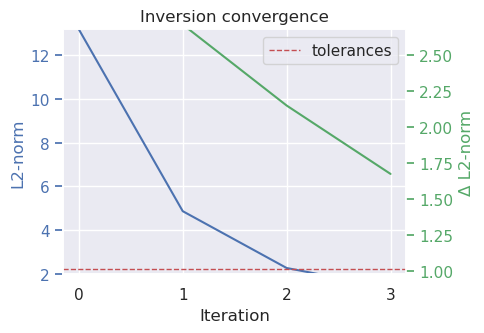

In [30]:
inv.plot_convergence()

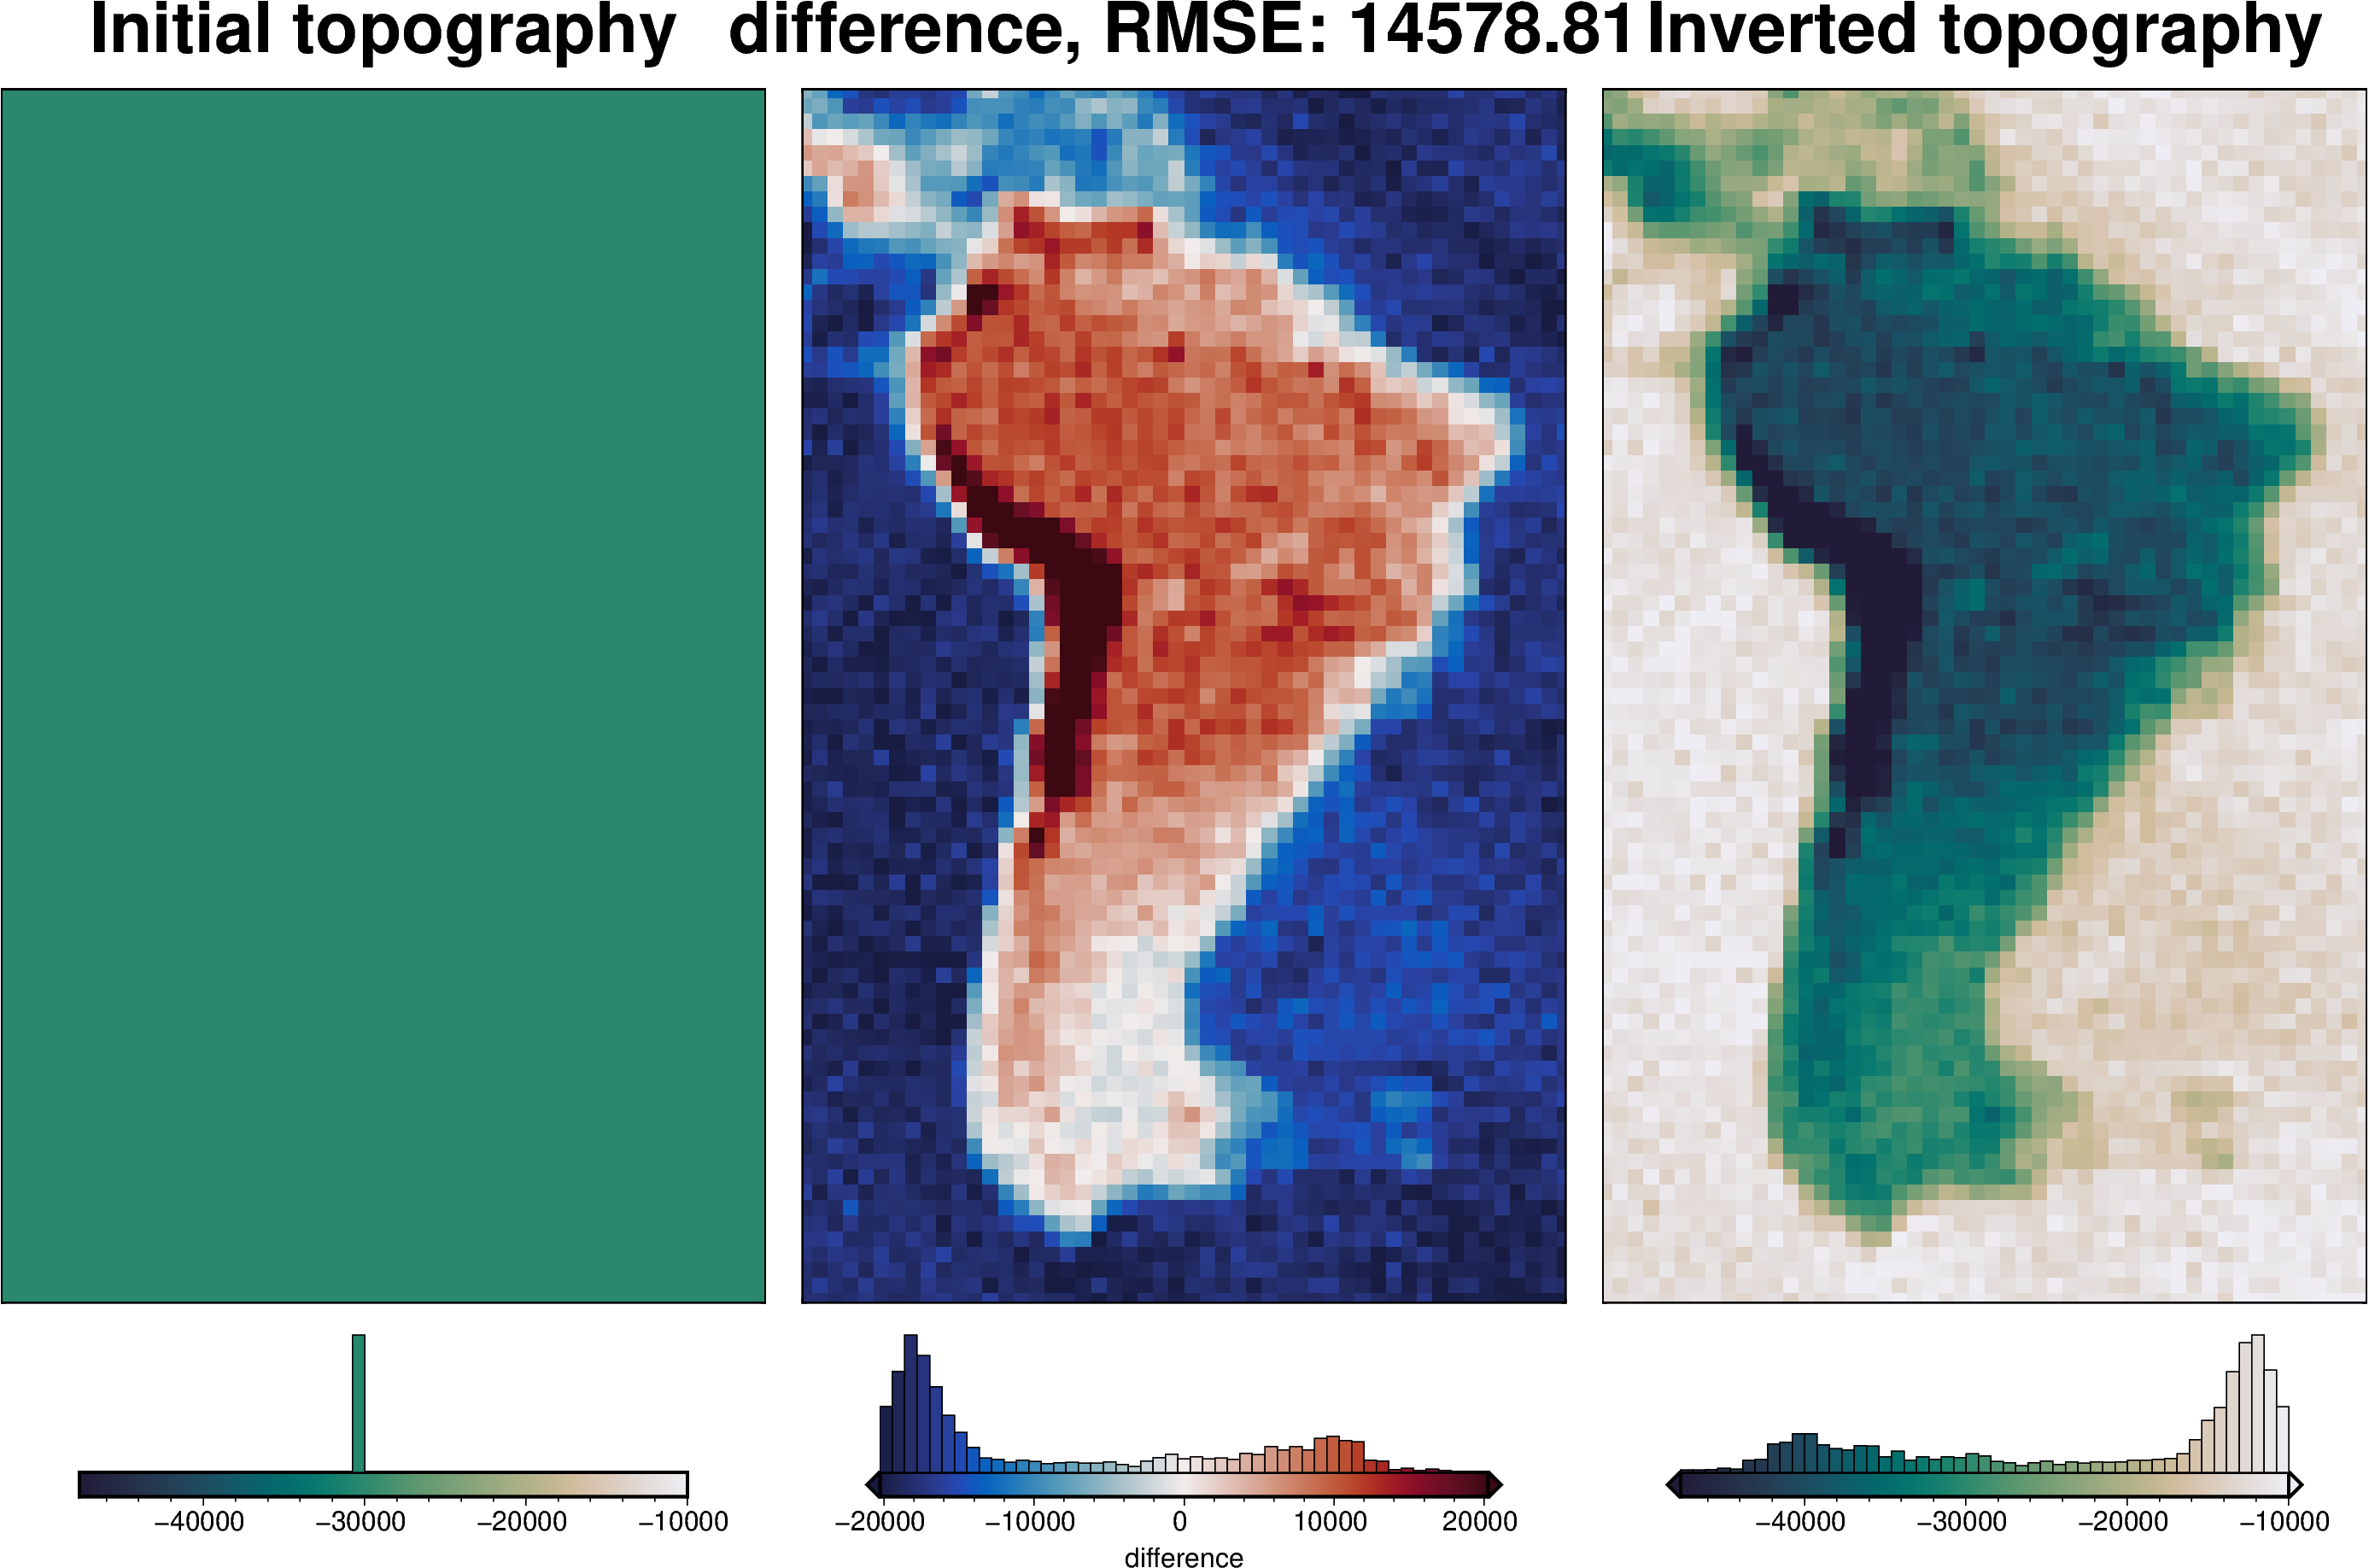

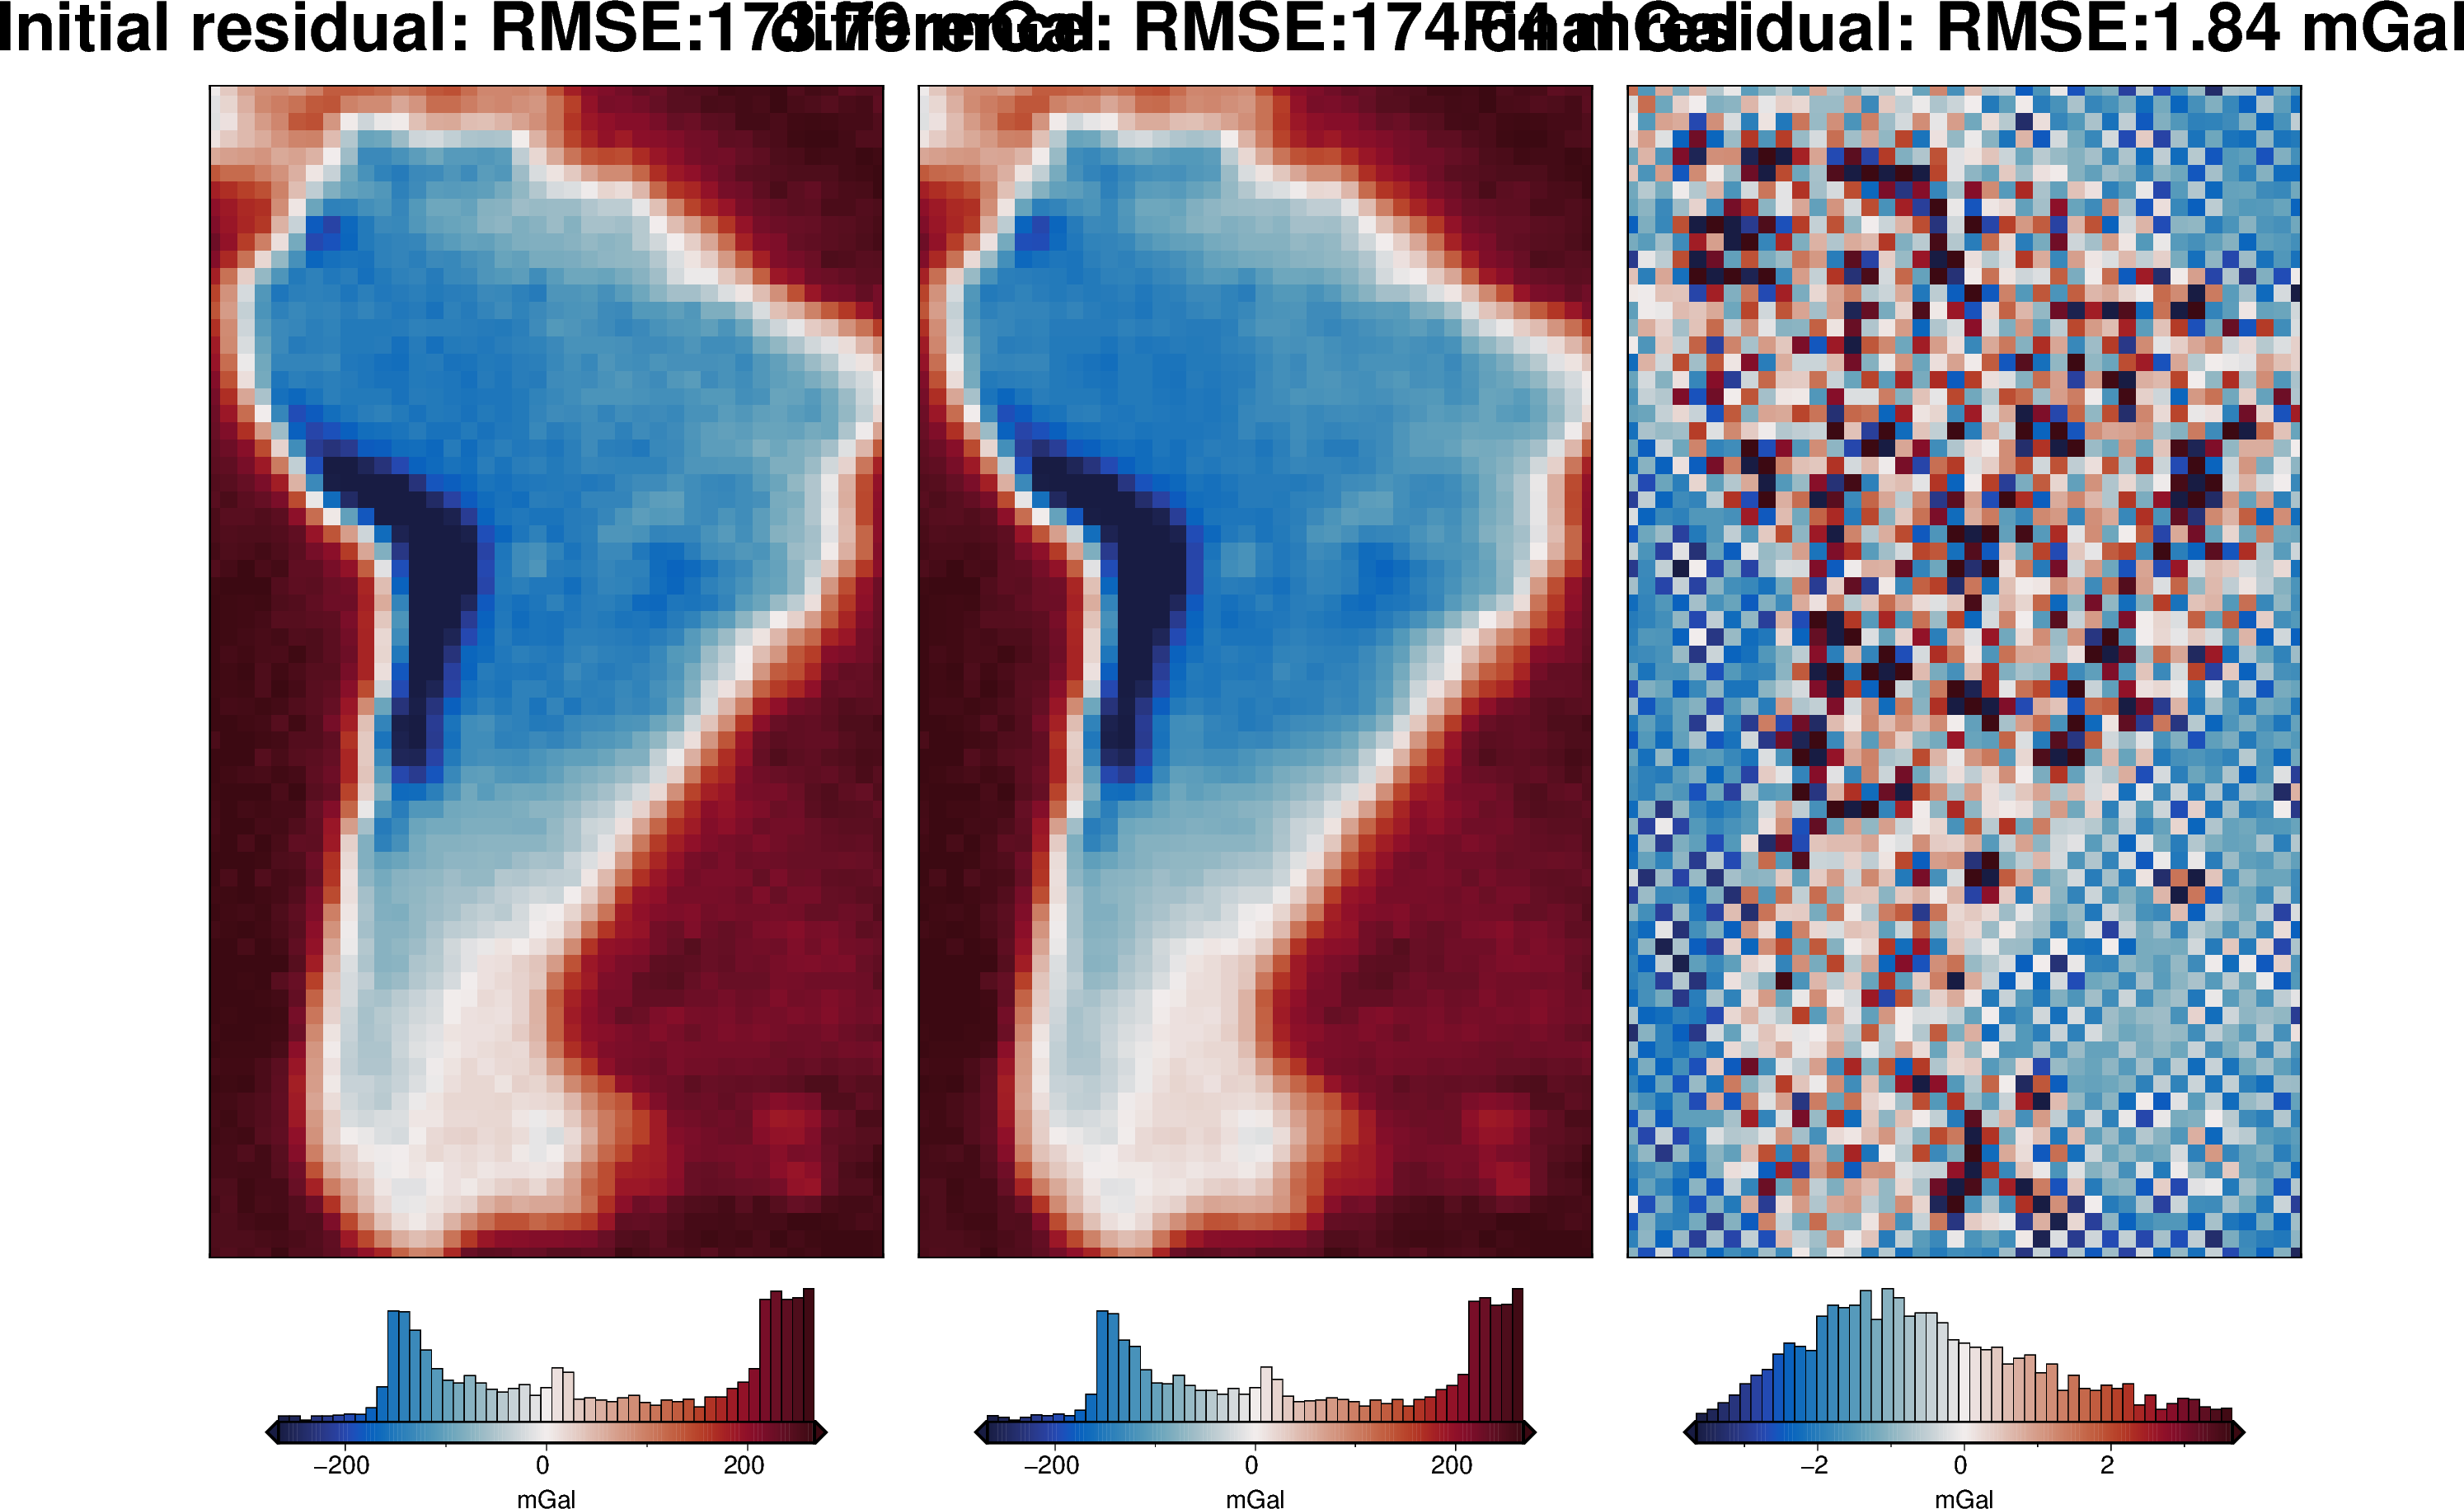

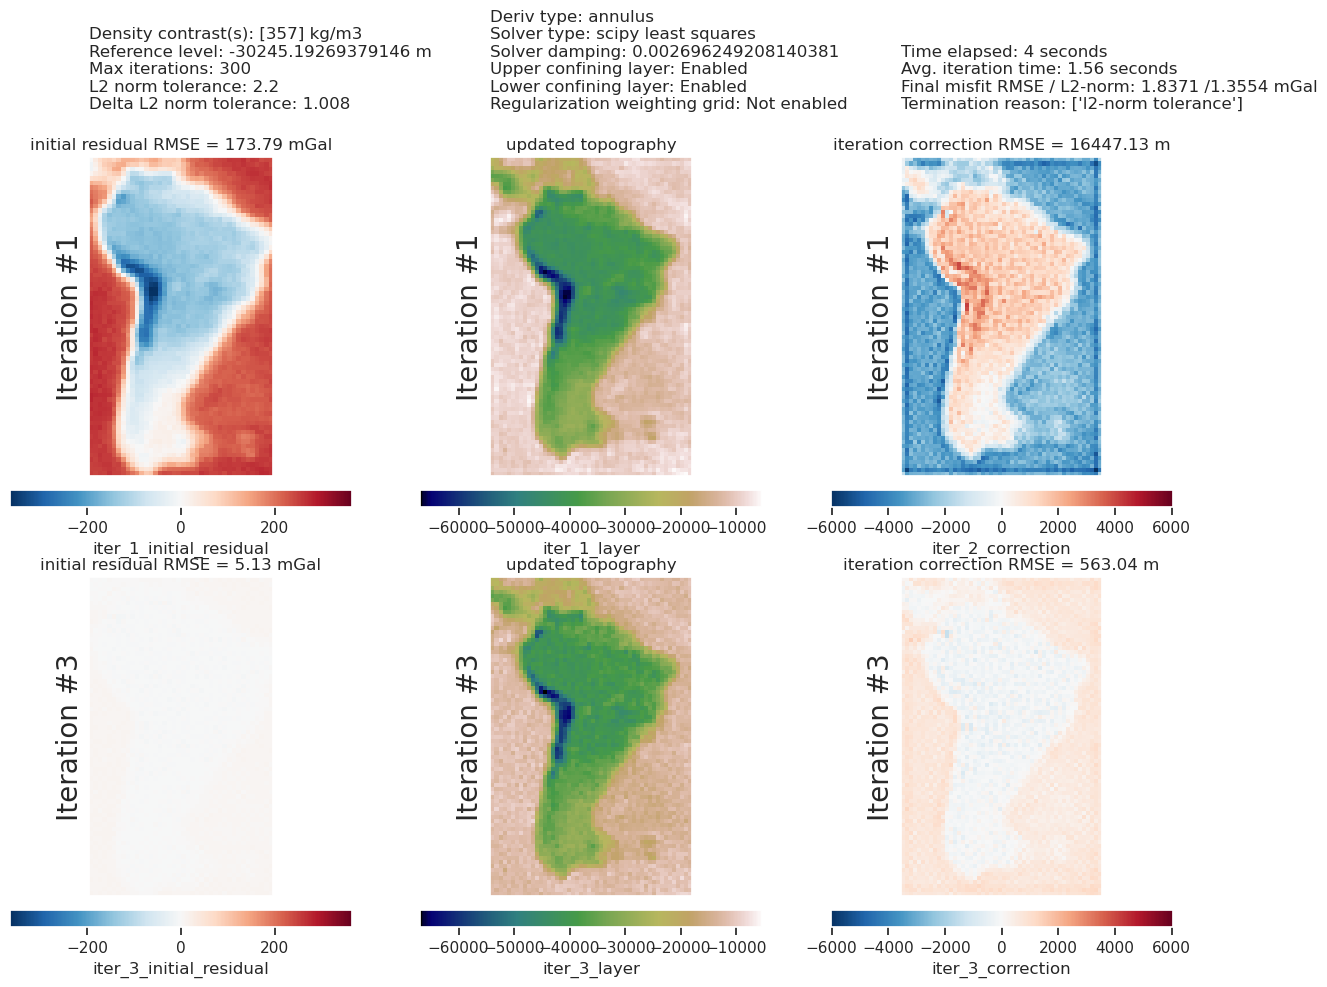

In [31]:
inv.plot_inversion_results(iters_to_plot=2)

The second plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 7g in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 3 iterations due to the inversion reaching the set L2-norm tolerance. 

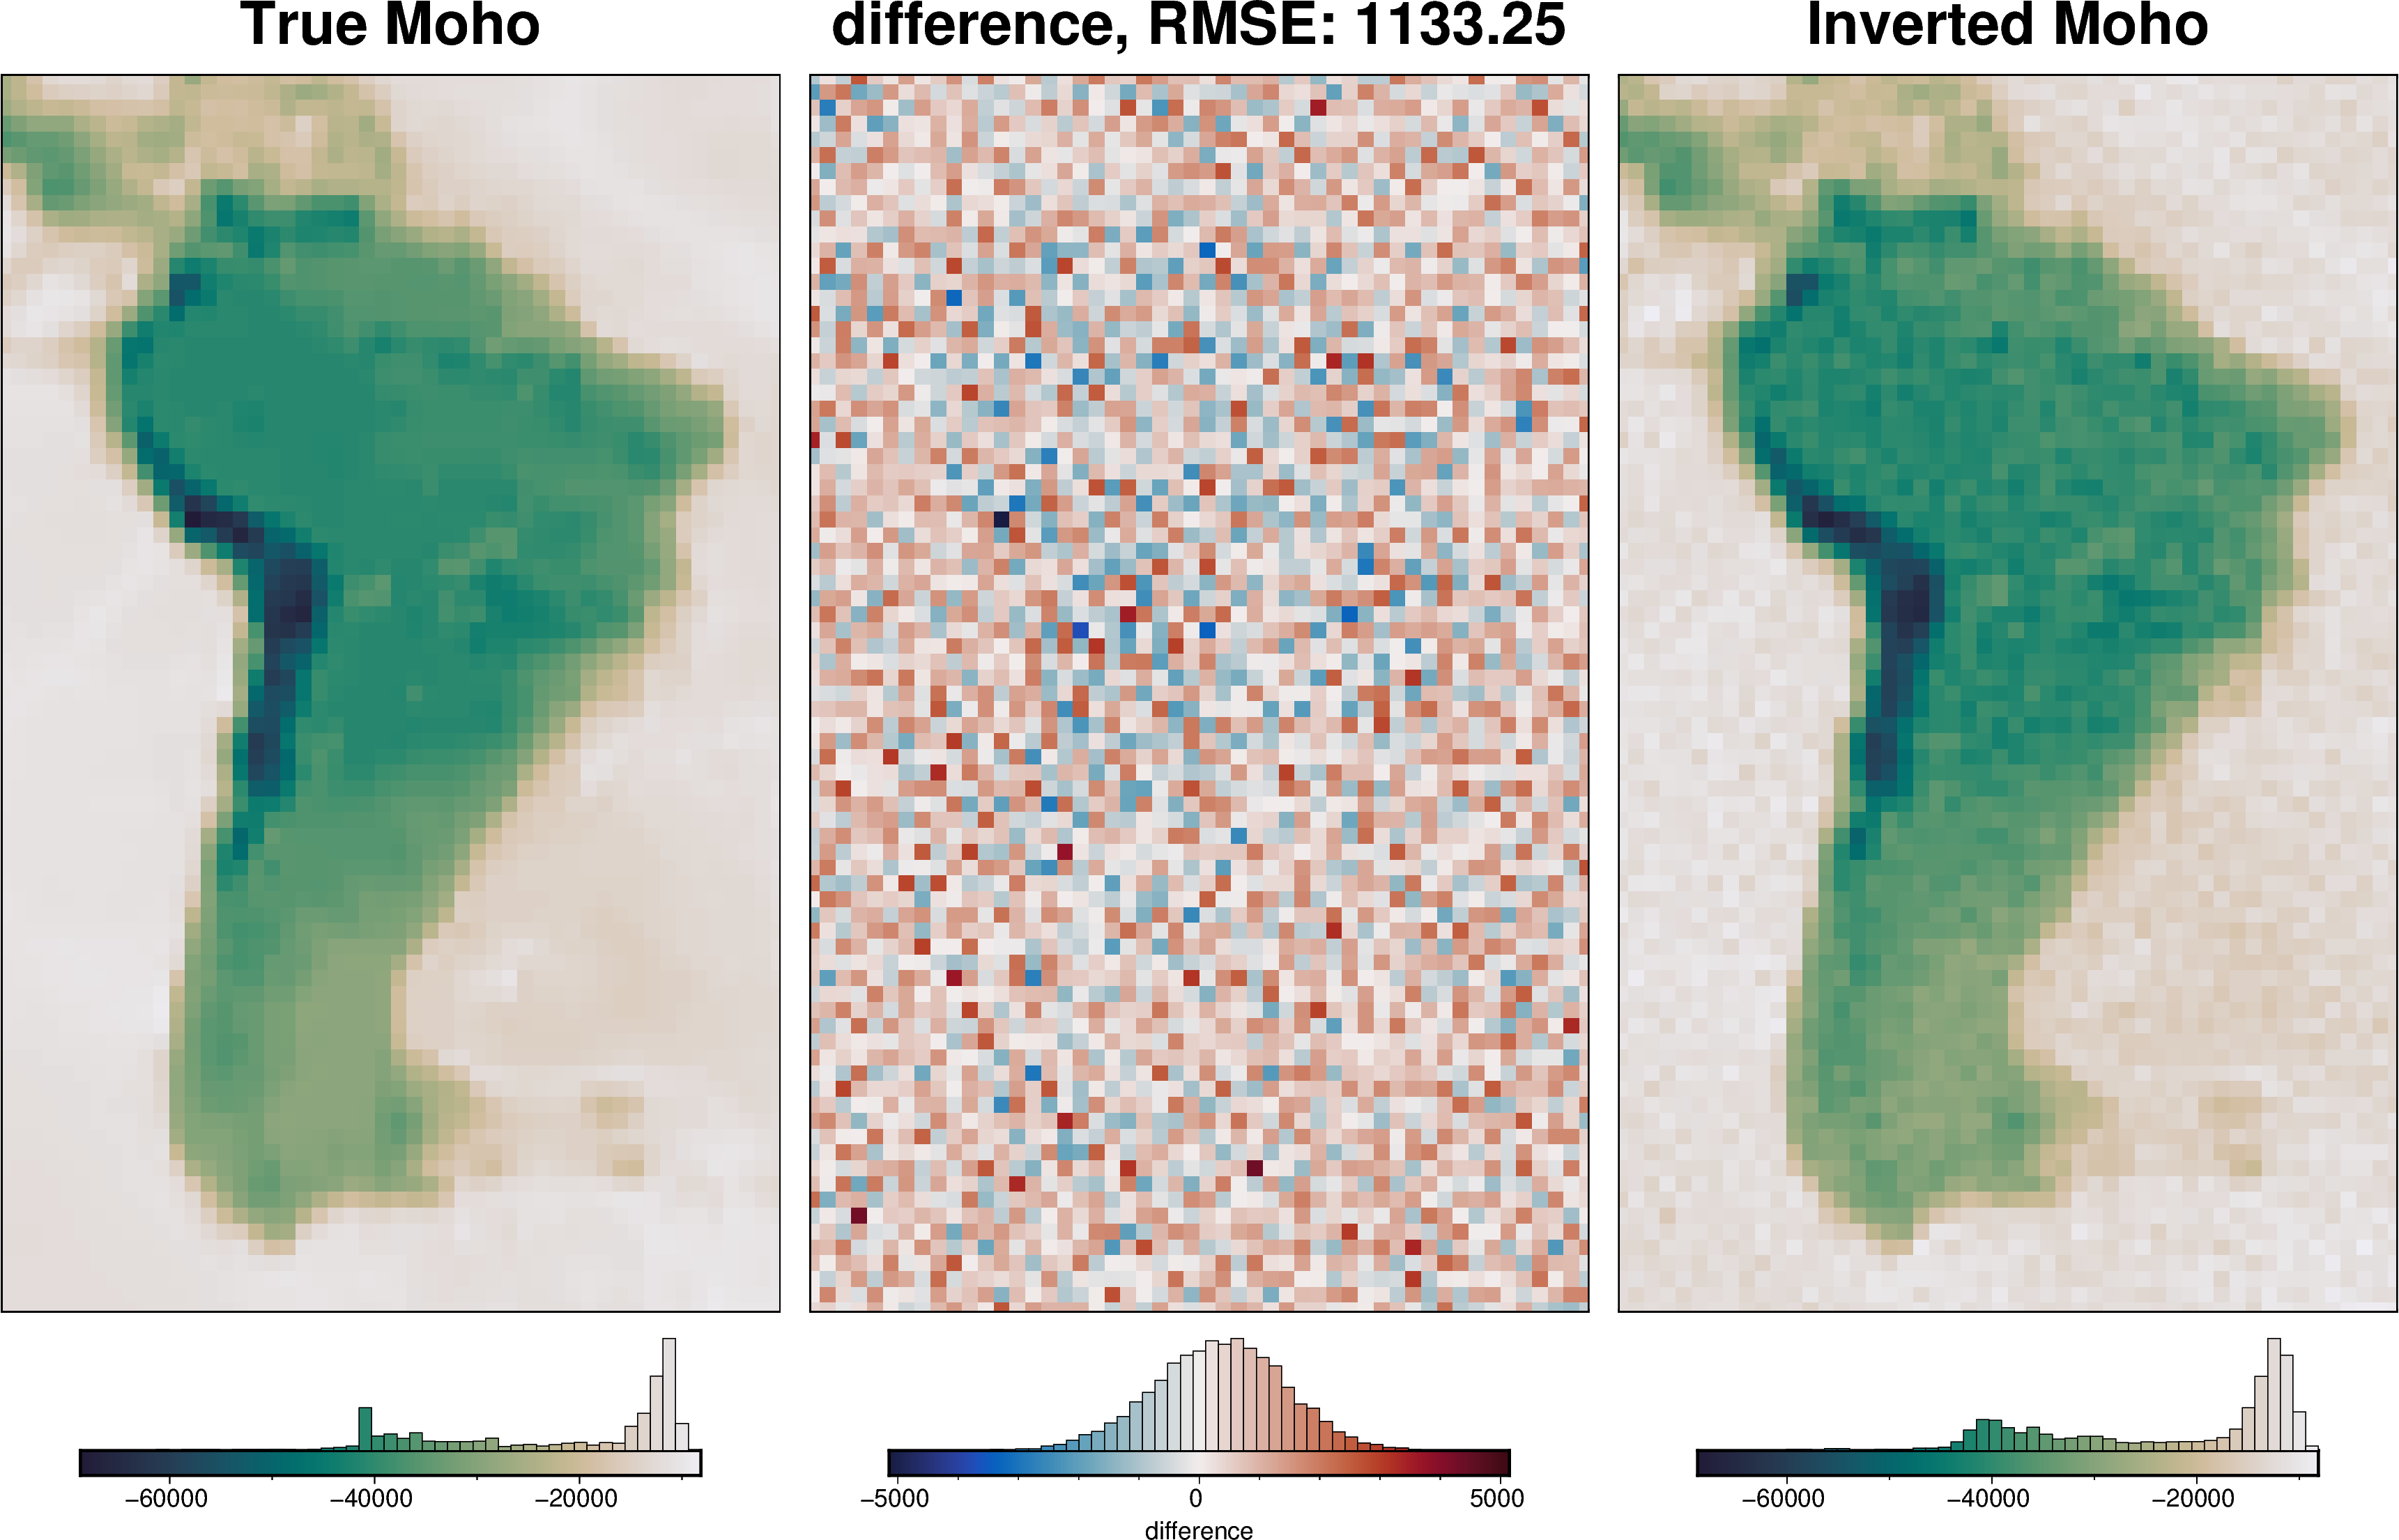

In [32]:
_ = polar_utils.grd_compare(
    true_moho,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

The above plot shows the difference between the true and inverted topography and is equivalent to Figure 6d in the paper. The colorbar histogram of the middle subplot is equivalent to Figure 6f. The errors are normally distributed around ~0, with a RMS of ~1100 m.

In [33]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 1050.73 m


# Repeat with adhering to constraints
the above inversions only used the constraint points as a means to perform the cross validation. Below we will create a starting model from theses points and attempt to make the inversion adhere to the constraints.

## Starting model

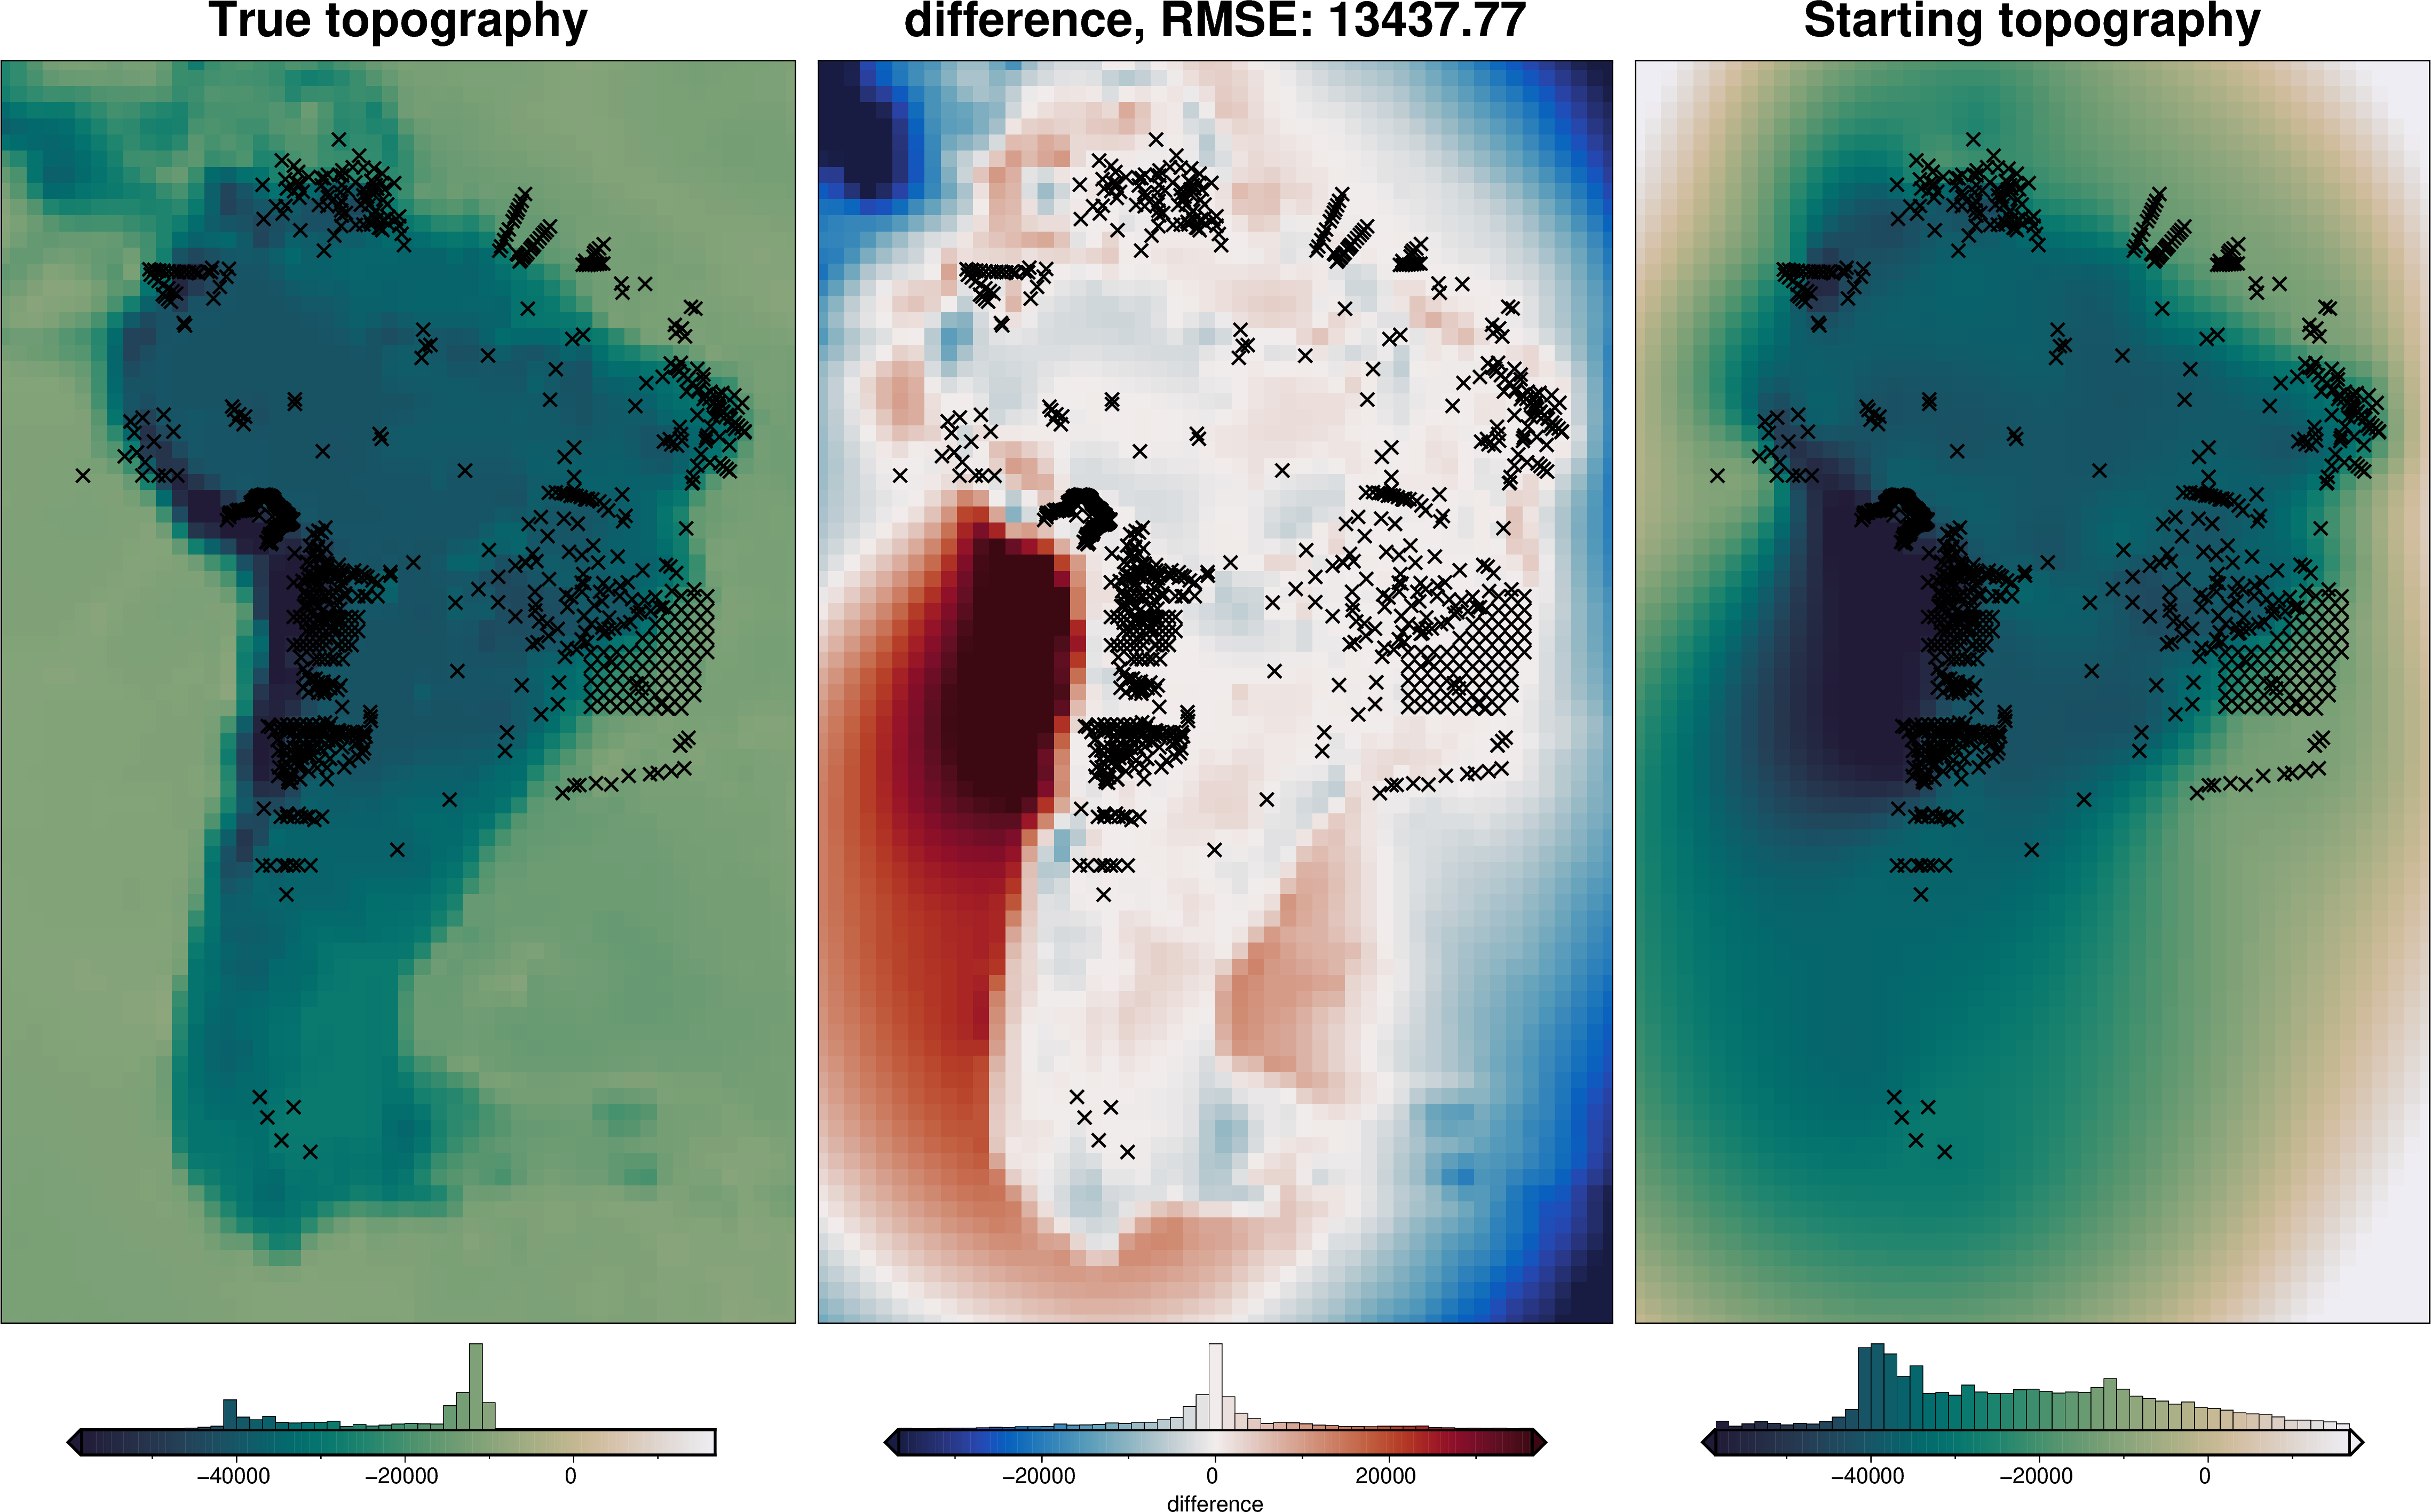

In [ ]:
# grid the sampled values using verde
starting_topography = invert4geom.create_topography(
    method="splines",
    region=grav_data.region,
    spacing=grav_data.spacing,
    constraints_df=constraint_points,
    dampings=None,  # np.logspace(-20, 0, 4),
)

_ = polar_utils.grd_compare(
    true_moho,
    starting_topography,
    fig_height=20,
    region=grav_data.region,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [35]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.starting_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 232.74 m


## Use a weighting grid
To ensure the inversion doesn't alter the starting model at the constraint points, where we know what the Moho elevation is, we can use a weighting grid. This scales each iterations correction values to be 0 at the constraint points. It's a good idea to redo the damping parameter CV when using this since the optimal damping value will likely change when you're using a weighting grid.

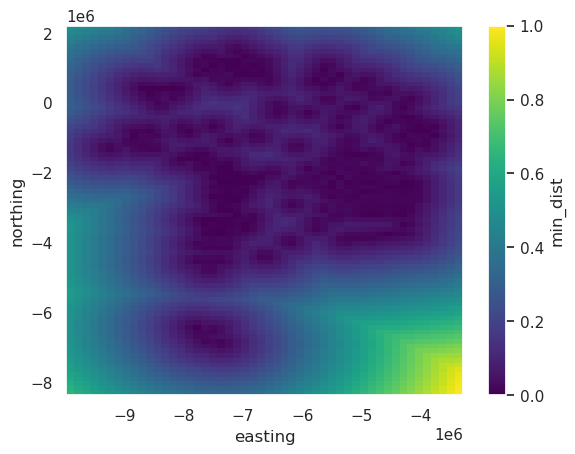

In [36]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = invert4geom.normalized_mindist(
    constraint_points,
    model.starting_topography,
    low=0,
    high=1,
)
weighting_grid.plot()

## Damping CV

In [37]:
inv.reinitialize_inversion()
inv.apply_weighting_grid = weighting_grid
inv.weighting_grid = weighting_grid

'starting_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True
'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

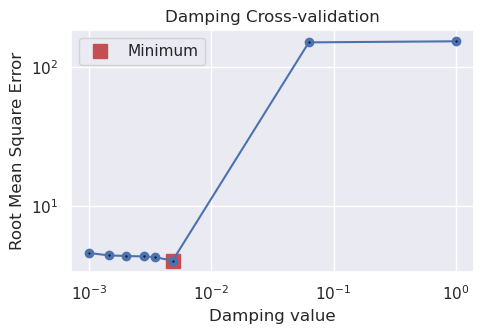

In [38]:
weighted_results = invert4geom.run_inversion_workflow(
    grav_ds=grav_data,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    run_damping_cv=True,
    constraints_df=constraint_points,
    density_contrast=inv.model.density_contrast,
    zref=inv.model.zref,
    fname="../tmp/uieda_CRUST1_with_starting_model",
    starting_topography=starting_topography.to_dataset(name="upward"),
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    inversion_kwargs={
        "max_iterations": 300,
        "l2_norm_tolerance": 2.2,
        "delta_l2_norm_tolerance": 1.008,
        "apply_weighting_grid": True,
        "weighting_grid": weighting_grid,
    },
    damping_cv_kwargs={
        "damping_limits": (0.001, 1),
        "n_trials": 8,
        "plot_cv": True,
    },
)

In [39]:
# to re-load the inversion results from the saved pickle file
name = "../tmp/uieda_CRUST1_with_starting_model_results.pickle"
with pathlib.Path(name).open("rb") as f:
    inversion_results = pickle.load(f)

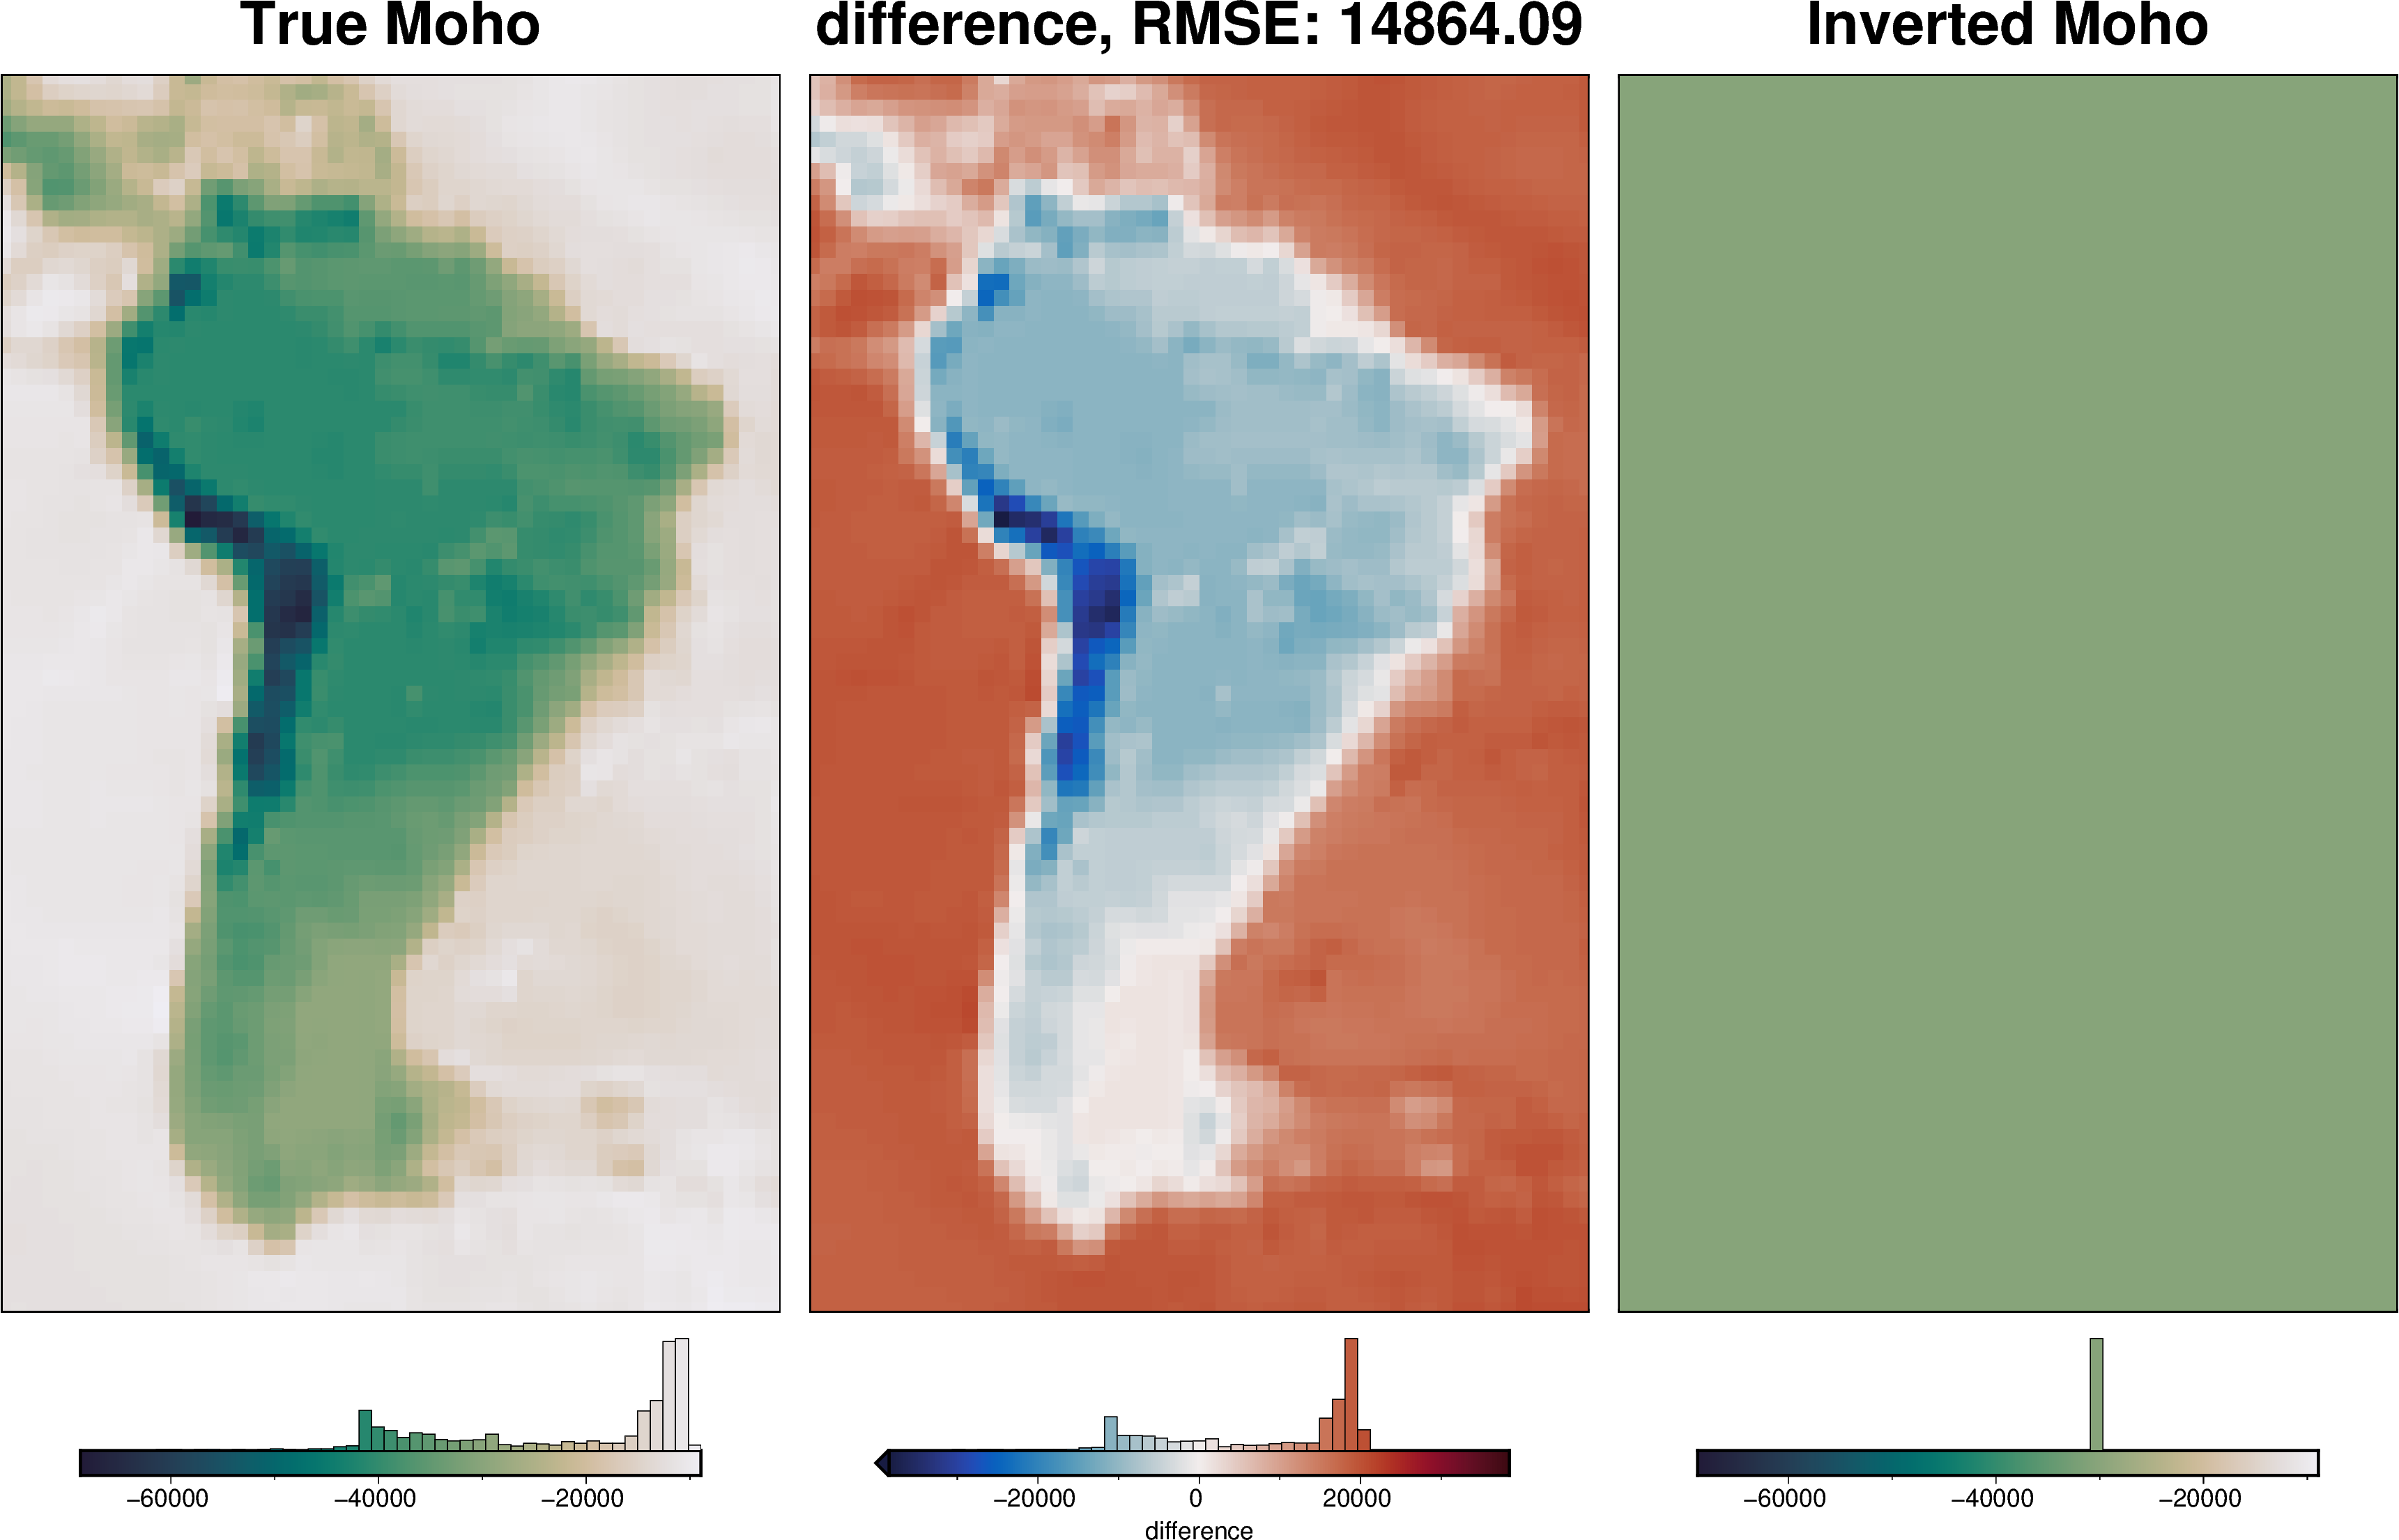

In [40]:
_ = polar_utils.grd_compare(
    true_moho,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

In [41]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 14539.59 m


The inversion error without a starting model was ~1100 m, and 1050 m at constraint points. Including a starting model reduced these both to 800 m and 570 m, respectively.

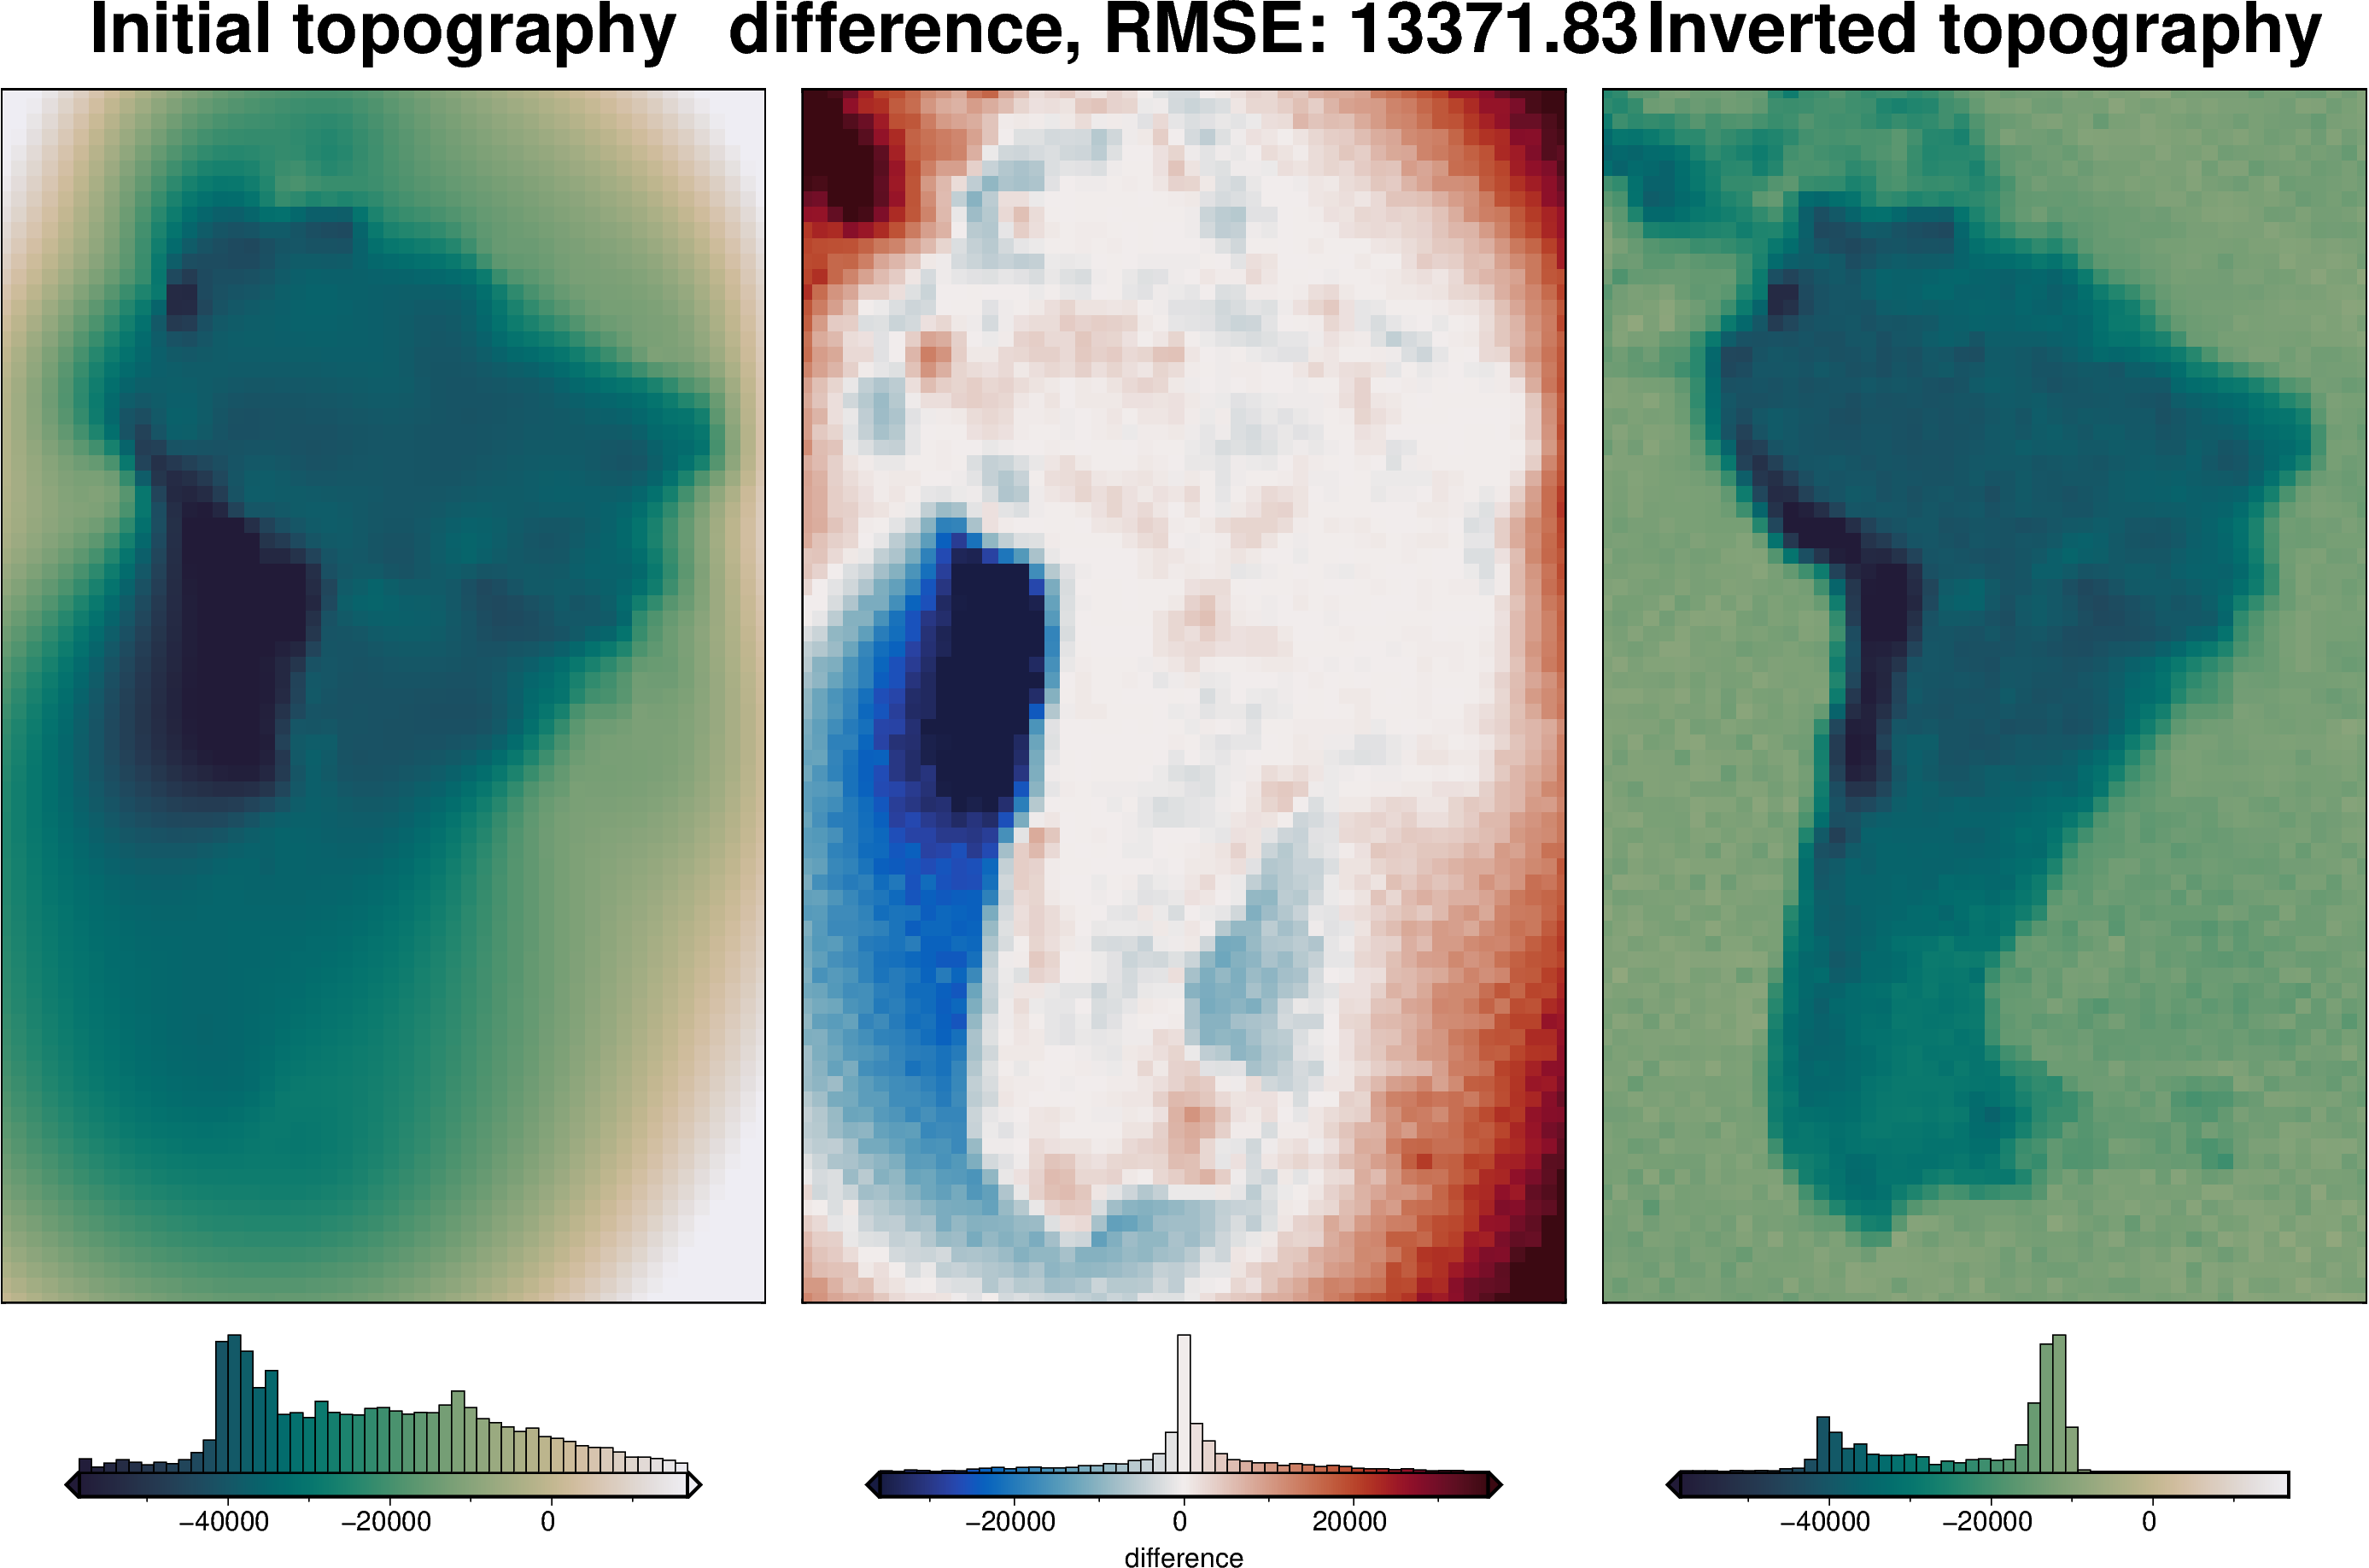

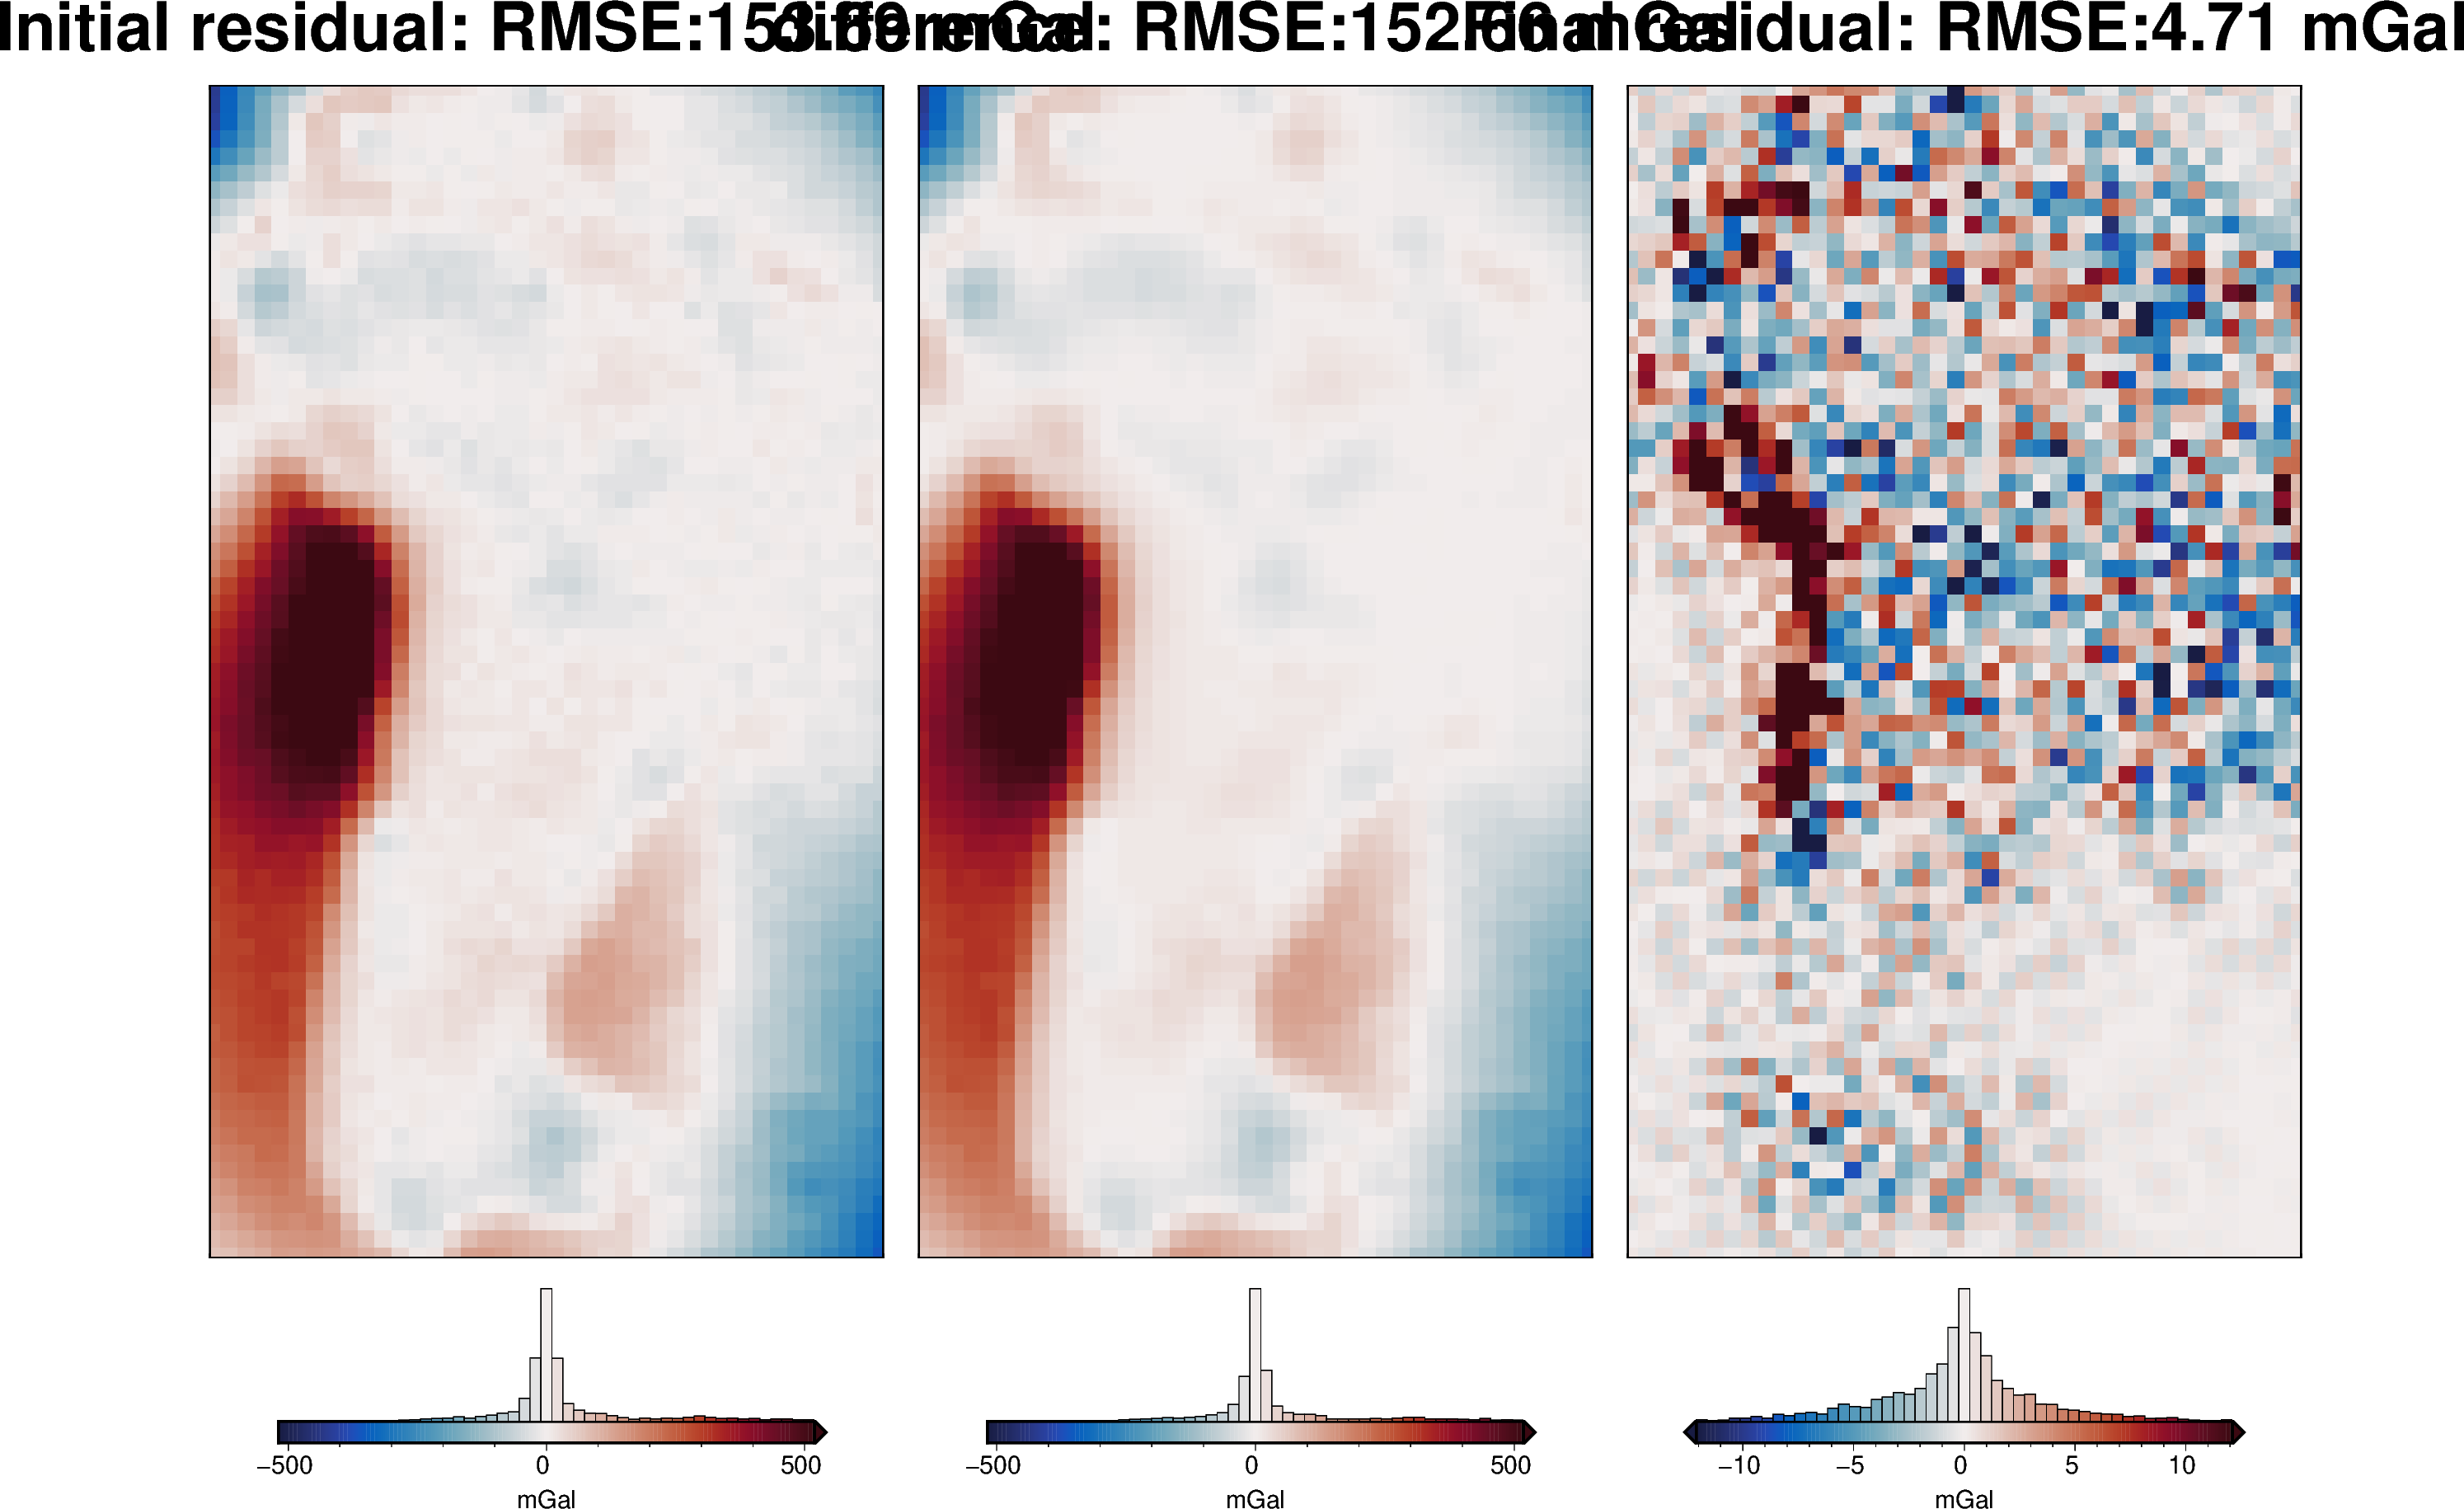

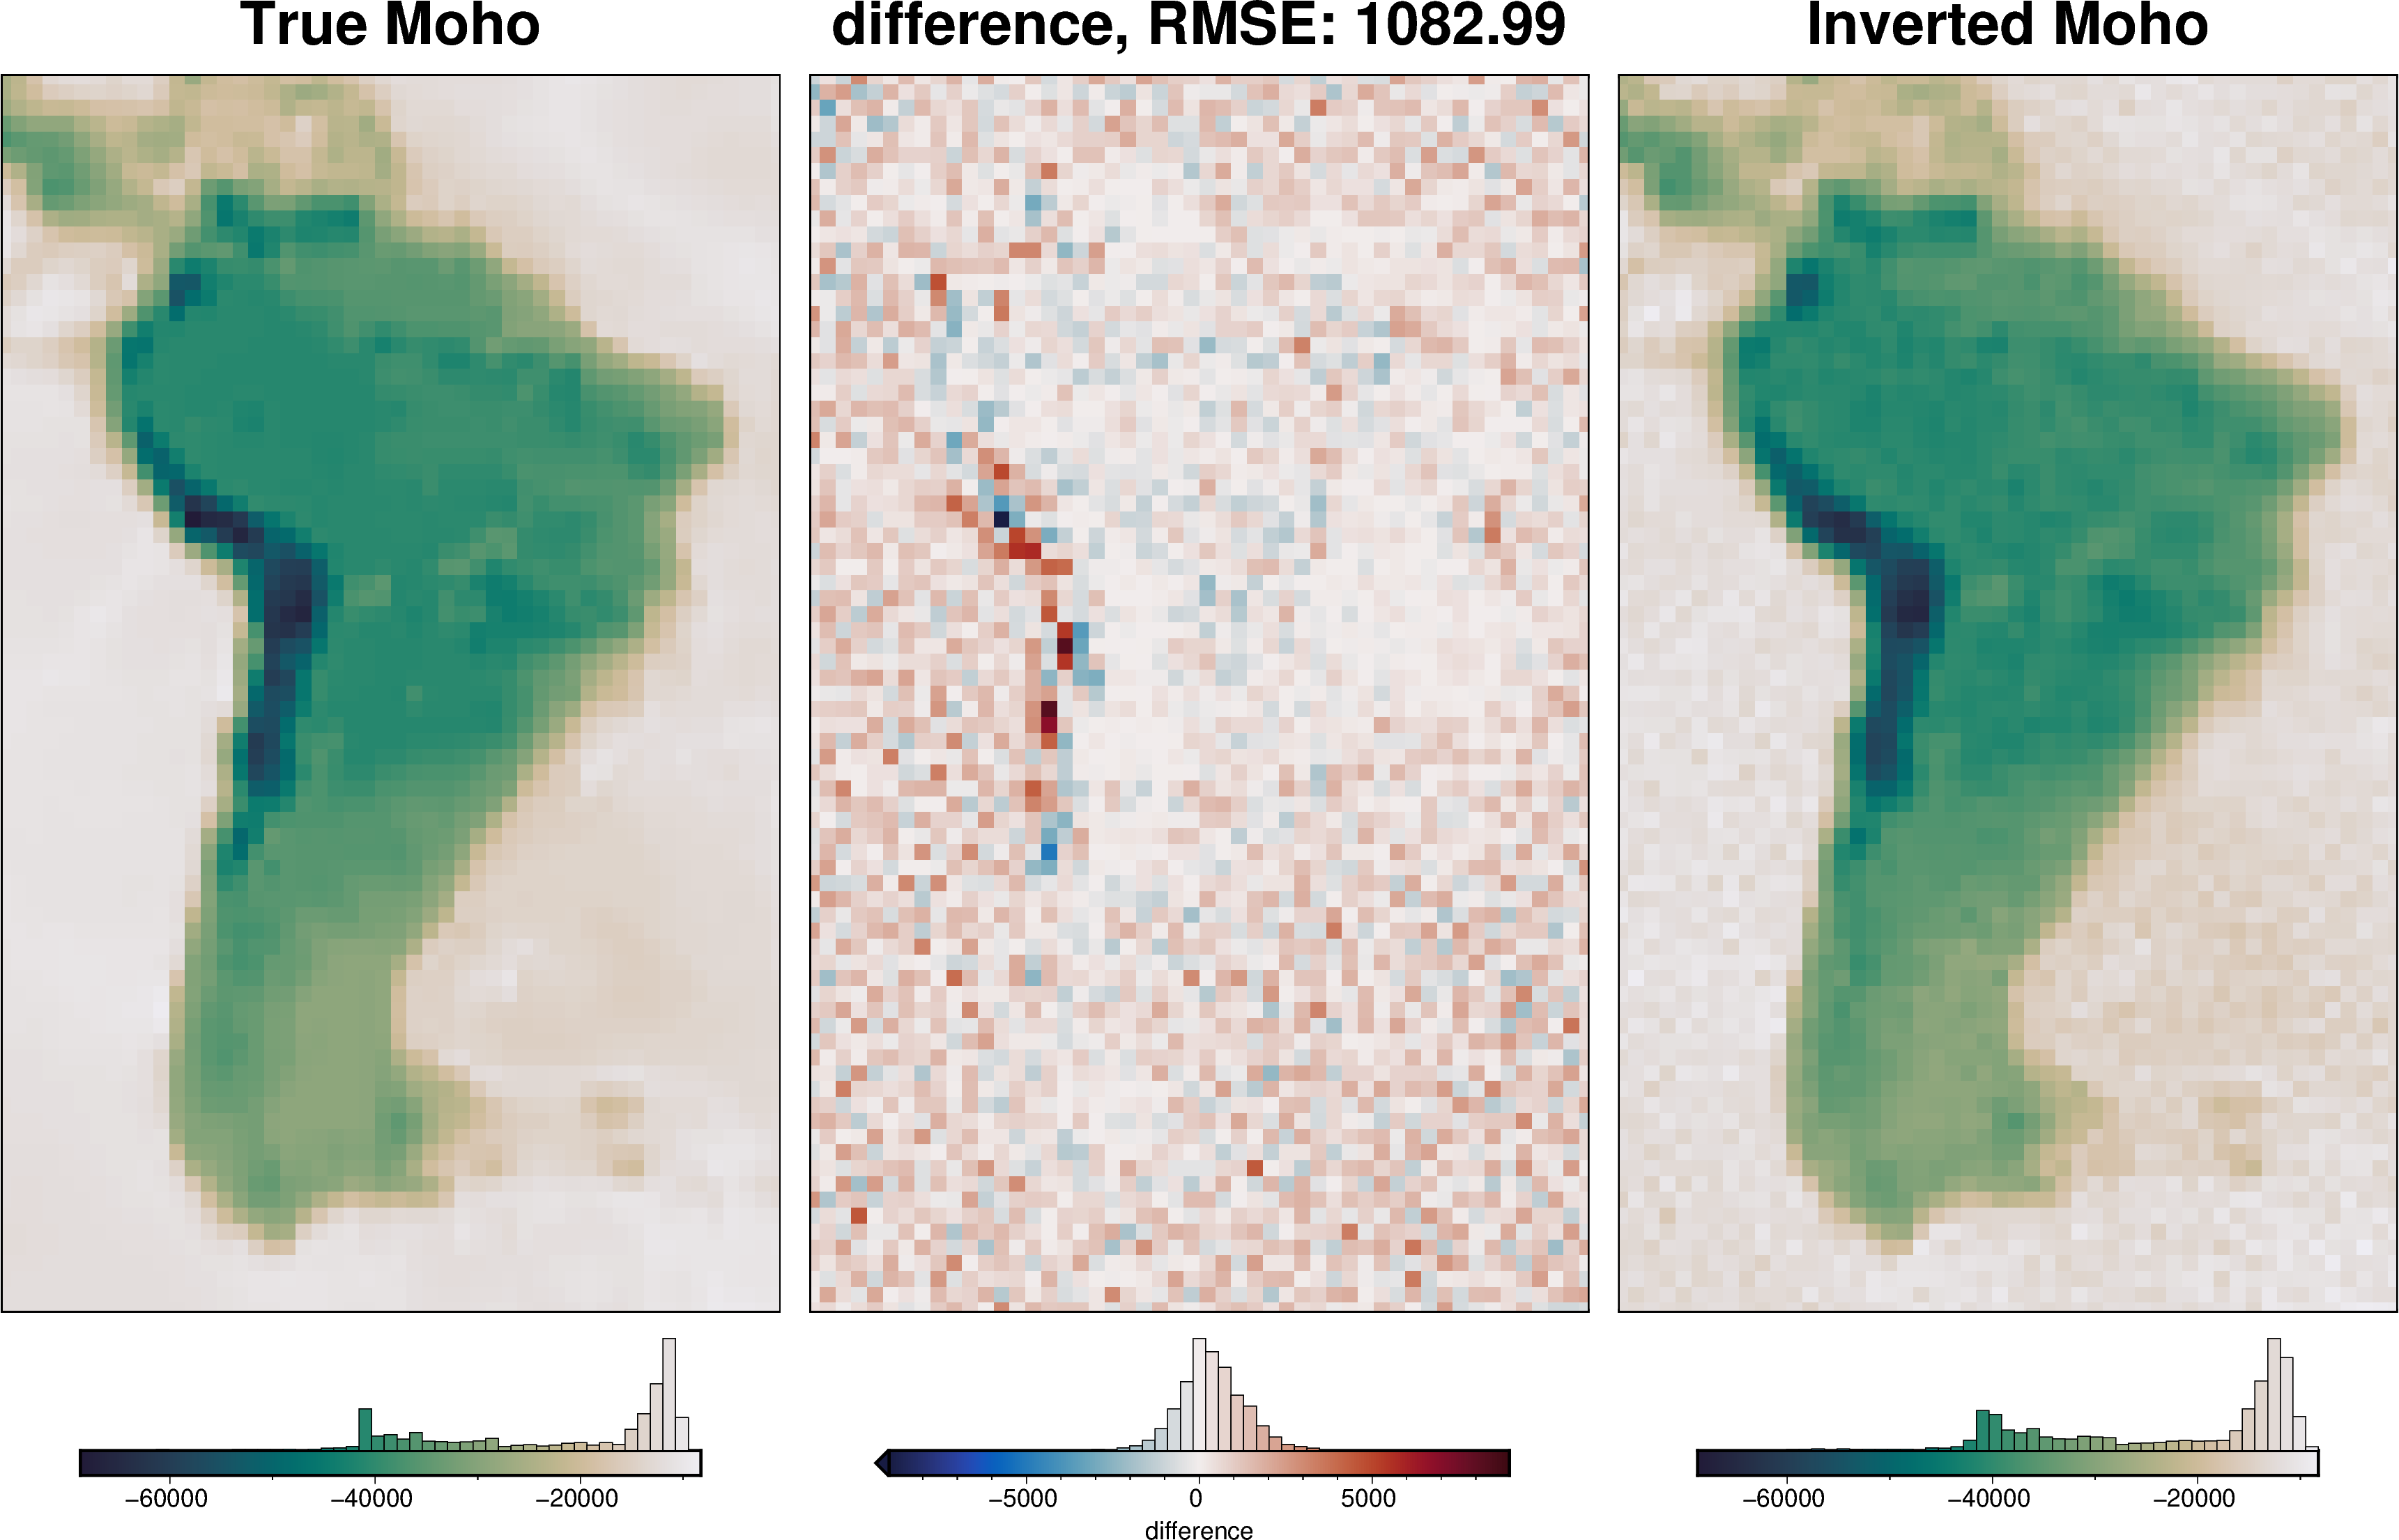

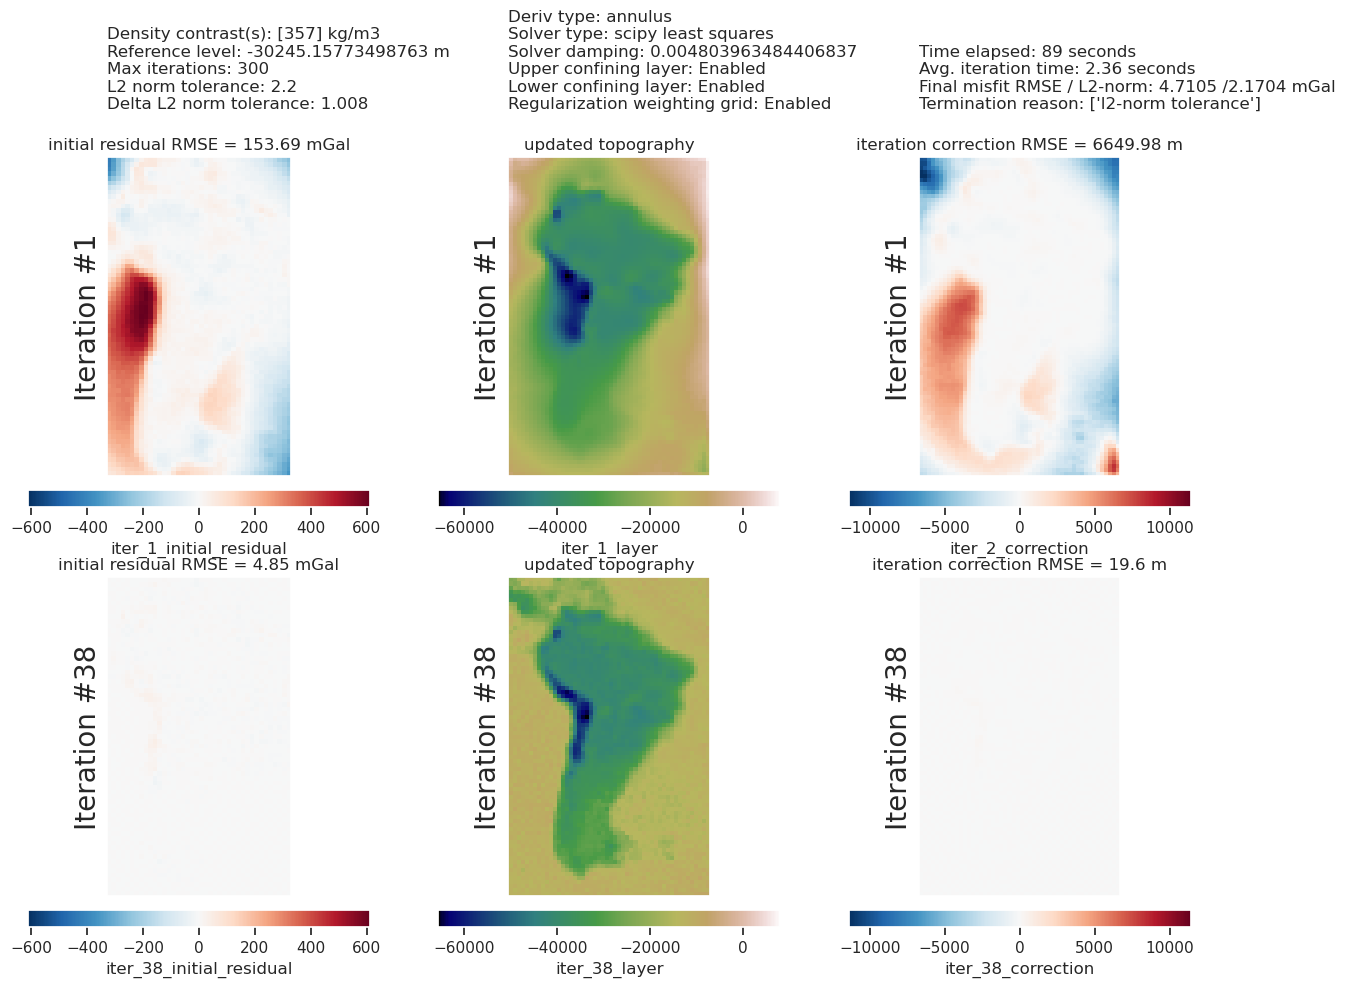

In [42]:
inversion_results.plot_inversion_results(iters_to_plot=2)

_ = polar_utils.grd_compare(
    true_moho,
    inversion_results.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

In [43]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inversion_results.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 227.73 m


As you can see, adding the weight grid has helped adhere to the constraint points. The RMSE at constraints without the weighting grid was 1300 m and 570 m, without and with a starting model, respectively. Including the weighting grid lowered this to 210 m.

However, overall this inversion performed worse. The overall RMSE without the weighting grid was 900 m and 800 m, , without and with a starting model, respectively. Using the weighting grid inclreased this to 1020 m.